# Задание

Познакомиться с задачей ***Named Entity Recognition*** (NER, распознавание именованных сущностей). Выполнить следующие шаги:
* Провести анализ данных (EDA).
* Выполнить задачу распознавания именованных сущностей на основе подхода с **использованием нейронных сетей**.
* Выполнить задачу распознавания именованных сущностей на основе **rule-based** подхода.
* Сравнить результаты, сделать выводы.

# Настройки/Импорты

Версии важных модулей:
* pandas==2.1.1
* numpy==1.26.2
* keras==2.10.0
* scikit_learn==1.2.2
* matplotlib==3.6.2

In [ ]:
import numpy as np # для работы с массивами
import pandas as pd # для удобной работы с датасетом
import pickle # для сохранения файлов

from tqdm.auto import tqdm # для отслеживания прогресса

from keras.preprocessing.text import Tokenizer # токенизатор текста (на версии keras 2.15.0 можно не тягать из tensorflow)
from keras.utils import pad_sequences # для приведения векторов токенов к единой размерности
import keras.backend as K # для работы с базовыми функциями keras

from sklearn.model_selection import train_test_split # для разбиения на обучающую и тестовую выборку

from keras.layers import Input, Dense, Concatenate, Dropout, Bidirectional, LSTM, TimeDistributed # слои для нейронной сети
from keras_nlp.layers import TokenAndPositionEmbedding # слои для нейронной сети
from keras.models import Model # Keras модель (не последовательная)
from keras.callbacks import ModelCheckpoint, EarlyStopping # callback функции
from keras.utils import to_categorical # для категоризации таргетов (приведения их к вероятностям 0 0 ... 1 ... 0 0)
import keras # для работы с моделью

import spacy # модуль для решения NLP задач
from spacy.matcher import Matcher # мэтчер для rule-based подхода

import time # для отслеживания времени выполнения
import matplotlib.pyplot as plt # для построения графиков
import seaborn as sns # для построения графиков
from wordcloud import WordCloud # для построения изображения с самыми часто встречаемыми словами (помогает в определении дополнительных стоп-слов)
from spacy import displacy # для вывода текста с помеченными сущностями
from IPython.display import Markdown # для вывода разноцветного текста
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay # для оценки качества предсказаний

import warnings # для обработки предупреждений
warnings.simplefilter(action='ignore', category=FutureWarning) # игнорируем FutureWarning

In [ ]:
DATA_DIR = "./data/" # путь до папки с данными
EMBEDDING_DIR = "./embeddings/" # путь до папки с эмбеддингами
MODELS_DIR = "./models/" # путь до папки с моделями
DATA_COL = "Word" # столбец, отвечающий за входные данные
TARGET_COL = "Tag" # столбец, отвечающий за таргеты
DTYPE = np.float32 # используемый тип

MAX_WORDS_TOKENIZER = 30000 # ограничение на число слов в словаре токенизатора (None — без ограничения)
EMBEDDING_DIM = 300 # размерность вектора-эмбеддинга слова

RANDOM_STATE = 42 # число для задания случайности
TEST_SIZE = 0.2 # размер тестовой выборки

EPOCHS_PATIENCE = 5 # число эпох без изменения наблюдаемой метрики, после которого обучение прекратится
EPOCHS = 50 # число эпох обучения
LEARNING_RATE = 0.0001 # learning rate
BATCH_SIZE = 50 # размер батча (число сэмплов, передаваемых в модель одновременно => чем больше значение - тем быстрее обучение, но хуже качество из-за аккумуляции градиентов)

In [3]:
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Используемый девайс: {DEVICE}.")

# Вспомогательные функции

In [ ]:
COLOR_MAPPING = {"O": "transparent",
                 "B-GEO": "green", "I-GEO": "green", 
                 "B-GPE": "orange", "I-GPE": "orange", 
                 "B-PER": "blue", "I-PER": "blue", 
                 "B-ORG": "darkred", "I-ORG": "darkred",
                 "B-TIM": "yellow", "I-TIM": "yellow", 
                 "B-ART": "pink", "I-ART": "pink", 
                 "B-NAT": "lime", "I-NAT": "lime", 
                 "B-EVE": "coral", "I-EVE": "coral"
                } # соотнесение цветов тегам (сущностям)

def print_tagged_text(words, tags) -> None:
    """
    Функция для вывода текста с изменённым цветом заднего плана, зависящим от сущности слова.\n
    Parameters
    -------
    * words : список слов для вывода
    * target_size : сущности выводимых слов
    Returns
    -------
    * None : выводит текст на экран
    """
    tagged_text = ""
    for word, tag in zip(words, tags): # идём по словам и тегам
        tagged_text += f"<span style='background-color: {COLOR_MAPPING[tag]};'>{word}</span> " # добавляем слово с окрашенным задником планом
    display(Markdown(tagged_text))

In [ ]:
def load_glove_vectors(file_name, specific_words=None) -> dict:
    """
    Функция для получения GloVe векторов из файла.\n
    Parameters
    -------
    * file_name : путь до файла с векторами
    * specific_words : None (если нужны все слова из словаря GloVe) или список (если нужны только определённые слова)
    Returns
    -------
    * dict : словарь вида {"слово": вектор-эмбеддинг, ...}
    """
    glove_vectors = {}
    with open(file_name, 'r') as f: 
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype=np.float32)
            if (specific_words is not None) and (word in specific_words): # если был передан перечень искомых слов и текущее слово из словаря GloVe  нём есть
                glove_vectors[word] = vector # записываем вектор слова в словарь
    return glove_vectors

# Предобработка датасета

## EDA

In [5]:
dataset = pd.read_csv(f"{DATA_DIR}NER_dataset.csv", sep=',', encoding='ansi', index_col=False) # считывание данных
dataset.dropna(axis=0, subset=[DATA_COL], inplace=True) # удаляем строки, в которых пропущены данные из колонок subset
dataset[["Word", "POS", "Tag"]] = dataset[["Word", "POS", "Tag"]].astype(str) # конвертируем колонки в необходимый тип
dataset.reset_index(drop=True, inplace=True) # обновляем индексы (drop=True — без сохранения старых индексов)
dataset

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
...,...,...,...,...
1048560,NaN,they,PRP,O
1048561,NaN,responded,VBD,O
1048562,NaN,to,TO,O
1048563,NaN,the,DT,O


В датасете используются следующие колонки:
* Sentence # — номер предложения (NaN означает, что запись относится к последнему встреченному предложению);
* Word — перечень слов в предложении;
* POS — часть речи, соответствующая каждому слову в предложении;
* Tag — метка именованной сущности, таргеты для задачи NER.

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048565 entries, 0 to 1048564
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  47949 non-null    object
 1   Word        1048565 non-null  object
 2   POS         1048565 non-null  object
 3   Tag         1048565 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


### Анализ частей речи

***Part Of Speech*** (POS) — тег части речи (существительное, глагол и т.д.). Используется для семантического анализа предложений и слов, а также улучшает качество предсказаний моделей (особенно в задаче NER).

![Part Of Speech](./images/POS.png)

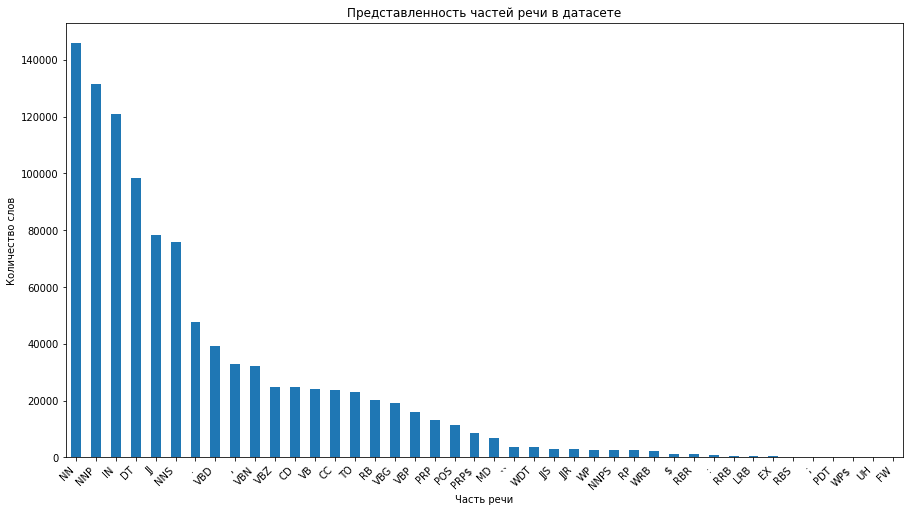

In [7]:
plt.figure(figsize=(15,8)) # задание размера фигуры
dataset["POS"].value_counts().plot.bar() # построение столбчатой диаграммы по данным
plt.xticks(rotation=45, ha='right') # поворот на 45 градусов подписей под осью OX (ha='right' ~ правый конец соответствует колонке)
plt.title("Представленность частей речи в датасете") # название фигуры
plt.xlabel("Часть речи") # подпись по оси x
plt.ylabel("Количество слов") # подпись по оси y
plt.show() # показ фигуры

### Анализ тегов (сущностей) слов

***Tag*** — разметка последовательности слов в BIO нотации:
* B-метка (beginning) проставляется для обозначения начала интересующей нас сущности, например B-org означает начало названия организации;
* I (inside) – для обозначения слова внутри нее (вплоть до конечного слова сущности), например I-org означает, что слово относится к названию организации, но при этом оно не идёт первым;
* O (outside) – это любое слово, что нам не интересно как сущность.

Такая нотация позволяет выделить в тексте границы именованных сущностей и их тип.

![BIO notation](./images/BIO.png)

In [8]:
dataset[TARGET_COL] = dataset[TARGET_COL].apply(lambda x: x.upper()) # приводим таргеты к верхнему регистру

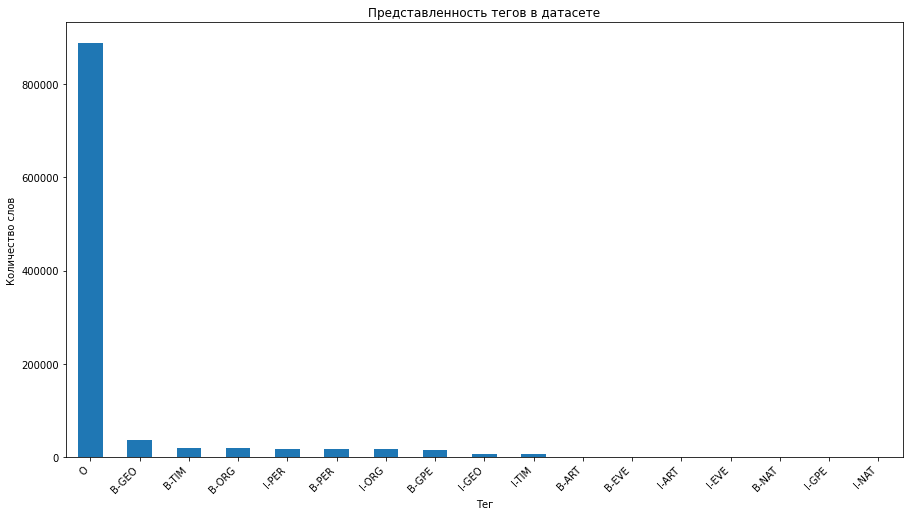

In [9]:
plt.figure(figsize=(15,8)) # задание размера фигуры
dataset[TARGET_COL].value_counts().plot.bar() # построение столбчатой диаграммы по данным
plt.xticks(rotation=45, ha='right') # поворот на 45 градусов подписей под осью OX (ha='right' ~ правый конец соответствует колонке)
plt.title("Представленность тегов в датасете") # название фигуры
plt.xlabel("Тег") # подпись по оси x
plt.ylabel("Количество слов") # подпись по оси y
plt.show() # показ фигуры

По графикам можно заметить, что в датасете больше всего данных не имеет явной сущности, то есть у них стоит обобщающий тег — "O".

Данный факт может сказаться на дальнейшем обучении моделей, так как это явный дисбаланс классов.

In [10]:
tags_sns = dataset[["Tag"]].copy() # копируем данные о таргетах
tags_sns["Tag simple"] = tags_sns["Tag"].apply(lambda x: x.split("-")[-1]) # создаём колонку, в которой будет информация только о типе тега (без указания его позиции B или I)
tags_sns["Tag BIO"] = tags_sns["Tag"].apply(lambda x: x.split("-")[0]) # создаём колонку, в которой будет информация только о позиции тега (B или I)
print(tags_sns["Tag simple"].unique())

['O' 'GEO' 'GPE' 'PER' 'ORG' 'TIM' 'ART' 'NAT' 'EVE']


В данных присутствуют следующие теги:
* O (Other) — не именованная сущность (пример: of, have, demonstration)
* GEO (Geographical Entity) — географическая сущность (пример: Murray River, Mount Everest)
* GPE (Geopolitical Entity) — геополитическая сущность (пример: South East Asia, Midlothian)
* PER (Person) — персона или группа людей (пример: Eddy Bonte, President Obama)
* ORG (Organization) — название организации или компании (пример: Georgia-Pacific Corp., WHO)
* TIM (Time) — время и даты (пример: two fifty a.m., 1:30 p.m.)
* ART (Artifact) — произведения искусства, религии (пример: Black square, Islam)
* NAT (Natural) — природные объекты или явления, болезни (пример: Antarctic Circumpolar Current)
* EVE (Event) — конференция, фестиваль или некое историческое событие (пример: 2012 Summer Olympics)

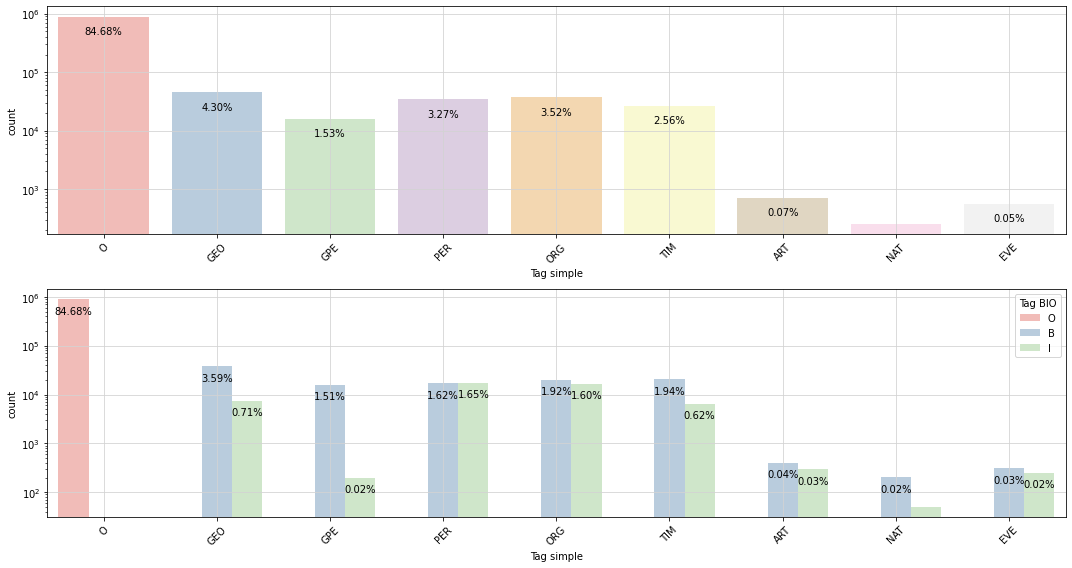

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,8)) # создание фигуры с несколькими осями (nrows, ncols) размера figsize
sns.countplot(x=tags_sns["Tag simple"], ax=axes[0], palette="Pastel1") # строим столбчатый график на оси ax с палитрой palette
sns.countplot(x=tags_sns["Tag simple"], ax=axes[1], palette="Pastel1", hue=tags_sns["Tag BIO"]) # строим столбчатый график на оси ax с палитрой palette и разделением данных в зависимости от hue

total_words = len(tags_sns) # общее число слов в датасете
for ax in axes: # идём по созданным осям
    ax.set_yscale("log") # задаём скалирование данных по оси y
    ax.tick_params(axis='x', rotation=45) # задаём подписям на оси axis поворот на rotation градусов
    ax.grid(True, color="lightgray") # добавление сетки на оси
    for p in ax.patches: # идём по колонкам графика
        percentage = '{:.2f}%'.format(100 * p.get_height()/total_words) # подсчёт процентов, занимаемых данными
        x = p.get_x() + p.get_width()/2
        y = p.get_height()/2
        ax.annotate(percentage, (x, y), ha='center', fontsize=10, rotation=0) # добавление подписи на колонку
plt.tight_layout() # настройка отступов между и вокруг подфигур
plt.show() # показ фигуры

Можно заметить, что многие сущности состоят из одного слова (GEO, GPE, TIM, NAT), но некоторые всё же чаще встречаются в виде нескольких слов (ORG, ART, EVE). И только сущность PER состоит, в основном, из двух и более токенов (I~Inside у них встречается чаще B~Beginning).

Также стоит обратить внимание на таргеты, что встречаются слишком редко (< 0.5% от общего размера датасета). Так как сэмплов с ними очень мало, то и моделям будет их гораздо сложнее предсказывать (в особенности, если такие теги у токена не единственные встречаемые).

### Отображение самых частых слов в датасете

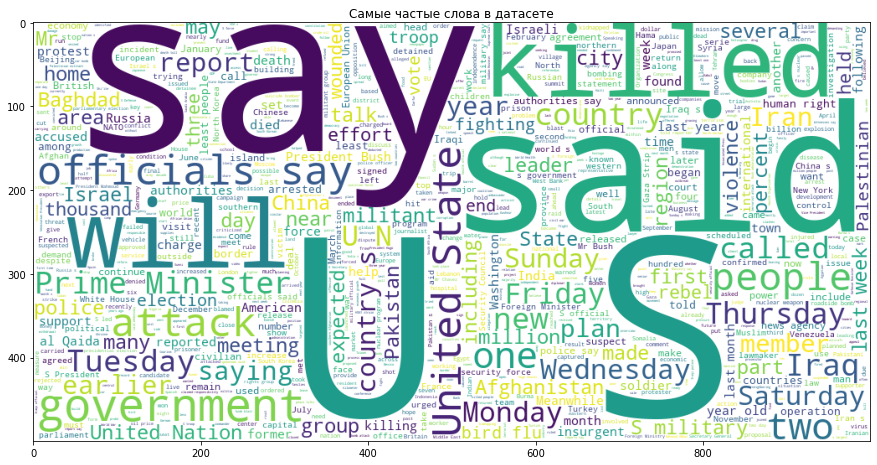

In [12]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=1000, height=500, random_state=RANDOM_STATE) # создание WordCloud объекта
wordcloud.generate(" ".join(dataset[DATA_COL])) # отправляем в WordCloud весь текст из датасета

plt.figure(figsize=(15,10)) # задание размера фигуры
plt.imshow(wordcloud) # отображение картинки
plt.title("Самые частые слова в датасете") # название фигуры
plt.show() # показ фигуры

## Векторизация датасета

*Датасет изначально представлен в хорошем качестве, предложения в нём уже разбиты на слова (токены) с указанием соответствующих частей речи и тегов (NER меток), поэтому его очистка проводиться не будет.*

Он лишь будет видоизменён для подачи в нейронную сеть. 

In [13]:
dataset["Sentence #"] = dataset["Sentence #"].apply(lambda x: x.split()[-1] if isinstance(x, str) else x) # конвертируем номер строки "Sentence: 1" ==> "1"
dataset["Sentence #"].ffill(inplace=True) # заполнение пропущенных данных последним встреченным валидным значением
dataset

,Sentence #,Word,POS,Tag
0,1,Thousands,NNS,O
1,1,of,IN,O
2,1,demonstrators,NNS,O
3,1,have,VBP,O
4,1,marched,VBN,O
...,...,...,...,...
1048560,47959,they,PRP,O
1048561,47959,responded,VBD,O
1048562,47959,to,TO,O
1048563,47959,the,DT,O


### Токенизация слов.

In [14]:
tokenizer = Tokenizer(num_words=MAX_WORDS_TOKENIZER, filters='', lower=False, split=" ", char_level=False, oov_token='<OOV>') # создаём объект токенизатора, с числом токенов, ограниченным num_words
tokenizer.fit_on_texts(dataset[DATA_COL]) # обучаем токенизатор на текстах

In [15]:
if MAX_WORDS_TOKENIZER is None: # если нет ограничения на число слов
    word2id = tokenizer.word_index # словарь соответствия слова его id_шнику (все слова в датасете)
    id2word = tokenizer.index_word # словарь соответствия id_шника слову (все слова в датасете)
else: # если есть ограничение на число слов
    word2id = {item[0]: item[1] for item in tokenizer.word_index.items() if item[1] < MAX_WORDS_TOKENIZER} # словарь соответствия слова его id_шнику (с версии tensorflow 2.16 словарь сразу обрезан по MAX_WORDS_TOKENIZER)
    id2word = {item[0]: item[1] for item in tokenizer.index_word.items() if item[0] < MAX_WORDS_TOKENIZER} # словарь соответствия id_шника слову (не ограничены MAX_FEATURES)

id2word[0] = "<pad>" # добавление токена пропуска (<pad>) под индексом 0
word2id["<pad>"] = 0 # добавление токена пропуска (<pad>) под индексом 0

vocab_size = len(id2word) # число слов в корпусе

print(f"Число уникальных токенов в корпусе: {vocab_size}.") # включая специальные токены
list(word2id.items())[:10] # первые 10 элементов словаря конвертации слова в токен (id)

Число уникальных токенов в корпусе: 30000.


[('<OOV>', 1),
 ('the', 2),
 ('.', 3),
 (',', 4),
 ('of', 5),
 ('in', 6),
 ('to', 7),
 ('a', 8),
 ('and', 9),
 ('The', 10)]

In [16]:
dataset["Word encoded"] = np.array(tokenizer.texts_to_sequences(dataset[DATA_COL])).flatten() # конвертируем слова в токены
dataset

,Sentence #,Word,POS,Tag,Word encoded
0,1,Thousands,NNS,O,1115
1,1,of,IN,O,5
2,1,demonstrators,NNS,O,1162
3,1,have,VBP,O,17
4,1,marched,VBN,O,1853
...,...,...,...,...,...
1048560,47959,they,PRP,O,56
1048561,47959,responded,VBD,O,2220
1048562,47959,to,TO,O,7
1048563,47959,the,DT,O,2


### Токенизация POS.

Проводим аналогичную токенизацию для POS значений.

In [ ]:
tokenizer_pos = Tokenizer(num_words=None, filters='', lower=False, split=" ", char_level=False, oov_token='<OOV>') # создаём объект токенизатора, с числом токенов, ограниченным num_words
tokenizer_pos.fit_on_texts(dataset["POS"]) # обучаем токенизатор на текстах

pos2id = tokenizer_pos.word_index # словарь соответствия POS его id_шнику
id2pos = tokenizer_pos.index_word # словарь соответствия id_шника POS

id2pos[0] = "<pad>" # добавление токена пропуска (<pad>) под индексом 0
pos2id["<pad>"] = 0 # добавление токена пропуска (<pad>) под индексом 0

pos_size = len(id2pos) # число уникальных POS в корпусе

print(f"Число уникальных POS в корпусе: {vocab_size}.") # включая специальные токены
pos2id # словарь конвертации POS в id (токен)

Число уникальных POS в корпусе: 44.


{'<OOV>': 1,
 'NN': 2,
 'NNP': 3,
 'IN': 4,
 'DT': 5,
 'JJ': 6,
 'NNS': 7,
 '.': 8,
 'VBD': 9,
 ',': 10,
 'VBN': 11,
 'VBZ': 12,
 'CD': 13,
 'VB': 14,
 'CC': 15,
 'TO': 16,
 'RB': 17,
 'VBG': 18,
 'VBP': 19,
 'PRP': 20,
 'POS': 21,
 'PRP$': 22,
 'MD': 23,
 '``': 24,
 'WDT': 25,
 'JJS': 26,
 'JJR': 27,
 'WP': 28,
 'NNPS': 29,
 'RP': 30,
 'WRB': 31,
 '$': 32,
 'RBR': 33,
 ':': 34,
 'RRB': 35,
 'LRB': 36,
 'EX': 37,
 'RBS': 38,
 ';': 39,
 'PDT': 40,
 'WP$': 41,
 'UH': 42,
 'FW': 43,
 '<pad>': 0}

In [18]:
dataset["POS encoded"] = np.array(tokenizer_pos.texts_to_sequences(dataset["POS"])).flatten() # конвертируем слова в токены
dataset

,Sentence #,Word,POS,Tag,Word encoded,POS encoded
0,1,Thousands,NNS,O,1115,7
1,1,of,IN,O,5,4
2,1,demonstrators,NNS,O,1162,7
3,1,have,VBP,O,17,19
4,1,marched,VBN,O,1853,11
...,...,...,...,...,...,...
1048560,47959,they,PRP,O,56,20
1048561,47959,responded,VBD,O,2220,9
1048562,47959,to,TO,O,7,16
1048563,47959,the,DT,O,2,5


### Кодирование тегов (таргетов)

In [19]:
unique_targets = list(dataset[TARGET_COL].unique()) # список уникальных предсказываемых значений (типов сущностей) в порядке их появления в датасете
# dataset["Tag encoded"] = [unique_targets.index(i) for i in dataset[TARGET_COL]] # создаём колонку с номерами таргетов (энкодим таргеты)
dataset["Tag encoded"] = pd.factorize(dataset[TARGET_COL])[0] # создаём колонку с номерами таргетов (энкодим таргеты)

dataset

,Sentence #,Word,POS,Tag,Word encoded,POS encoded,Tag encoded
0,1,Thousands,NNS,O,1115,7,0
1,1,of,IN,O,5,4,0
2,1,demonstrators,NNS,O,1162,7,0
3,1,have,VBP,O,17,19,0
4,1,marched,VBN,O,1853,11,0
...,...,...,...,...,...,...,...
1048560,47959,they,PRP,O,56,20,0
1048561,47959,responded,VBD,O,2220,9,0
1048562,47959,to,TO,O,7,16,0
1048563,47959,the,DT,O,2,5,0


### Объединение данных в целостные предложения

In [20]:
dataset = dataset.groupby(by="Sentence #").agg({"Word": list, "POS": list, "Tag": list, "Word encoded": list, "POS encoded": list, "Tag encoded": list}) # groupby — группируем данные по одинаковым значениям колонки by; agg — агрегируем колонки в соответствующие типы 
dataset

,Word,POS,Tag,Word encoded,POS encoded,Tag encoded
Sentence #,,,,,,
1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-GEO, O, O, O, O, O, B-GEO...","[1115, 5, 1162, 17, 1853, 230, 479, 7, 534, 2,...","[7, 4, 7, 19, 11, 4, 3, 16, 14, 5, 2, 4, 3, 15...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ..."
10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-GPE, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[320, 42, 25, 56, 1831, 7, 766, 1037, 7, 4660,...","[6, 7, 19, 20, 19, 16, 14, 2, 16, 6, 6, 7, 4, ...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-TIM, O, O, O, O, O, B-GEO, O, O, O, O...","[20411, 4665, 92, 5247, 281, 5035, 6, 2, 4478,...","[2, 7, 3, 9, 6, 7, 4, 5, 3, 6, 2, 10, 31, 6, 3...","[0, 0, 7, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 5, ..."
1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[205, 388, 45, 8, 4890, 15542, 3294, 18, 2825,...","[20, 9, 4, 5, 2, 6, 2, 4, 2, 7, 8]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-GEO, O, O, B-PER, I-PER, O, B-TIM, O, B-GEO...","[129, 711, 8190, 4142, 5607, 19, 87, 4, 26, 4,...","[3, 2, 2, 3, 3, 9, 3, 10, 3, 10, 6, 15, 6, 6, ...","[1, 0, 0, 3, 10, 0, 7, 0, 1, 0, 2, 0, 2, 0, 0,..."
...,...,...,...,...,...,...
9995,"[Opposition, leader, Mir, Hossein, Mousavi, ha...","[NNP, NN, NNP, NNP, NNP, VBZ, VBN, PRP, VBZ, T...","[O, O, O, B-PER, I-PER, O, O, O, O, O, O, O, O...","[2030, 127, 5602, 5627, 5374, 13, 19, 39, 329,...","[3, 2, 3, 3, 3, 12, 11, 20, 12, 16, 14, 15, 7,...","[0, 0, 0, 3, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
9996,"[On, Thursday, ,, Iranian, state, media, publi...","[IN, NNP, ,, JJ, NN, NNS, VBN, DT, NN, IN, DT,...","[O, B-TIM, O, B-GPE, O, O, O, O, O, O, O, O, B...","[304, 75, 4, 320, 130, 341, 851, 8, 1400, 22, ...","[4, 3, 10, 6, 2, 7, 11, 5, 2, 4, 5, 6, 6, 7, 1...","[0, 7, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, ..."
9997,"[Following, Iran, 's, disputed, June, 12, elec...","[VBG, NNP, POS, JJ, NNP, CD, NNS, ,, NNS, NNS,...","[O, B-GEO, O, O, B-TIM, I-TIM, O, O, O, O, O, ...","[2072, 77, 11, 1430, 502, 557, 145, 4, 247, 23...","[18, 3, 21, 6, 3, 13, 7, 10, 7, 7, 9, 7, 4, 7,...","[0, 1, 0, 0, 7, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [21]:
dataset.reset_index(drop=True, inplace=True) # обновляем индексы (drop=True — без сохранения старых индексов)
dataset

,Word,POS,Tag,Word encoded,POS encoded,Tag encoded
0,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-GEO, O, O, O, O, O, B-GEO...","[1115, 5, 1162, 17, 1853, 230, 479, 7, 534, 2,...","[7, 4, 7, 19, 11, 4, 3, 16, 14, 5, 2, 4, 3, 15...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ..."
1,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-GPE, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[320, 42, 25, 56, 1831, 7, 766, 1037, 7, 4660,...","[6, 7, 19, 20, 19, 16, 14, 2, 16, 6, 6, 7, 4, ...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-TIM, O, O, O, O, O, B-GEO, O, O, O, O...","[20411, 4665, 92, 5247, 281, 5035, 6, 2, 4478,...","[2, 7, 3, 9, 6, 7, 4, 5, 3, 6, 2, 10, 31, 6, 3...","[0, 0, 7, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 5, ..."
3,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[205, 388, 45, 8, 4890, 15542, 3294, 18, 2825,...","[20, 9, 4, 5, 2, 6, 2, 4, 2, 7, 8]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-GEO, O, O, B-PER, I-PER, O, B-TIM, O, B-GEO...","[129, 711, 8190, 4142, 5607, 19, 87, 4, 26, 4,...","[3, 2, 2, 3, 3, 9, 3, 10, 3, 10, 6, 15, 6, 6, ...","[1, 0, 0, 3, 10, 0, 7, 0, 1, 0, 2, 0, 2, 0, 0,..."
...,...,...,...,...,...,...
47944,"[Opposition, leader, Mir, Hossein, Mousavi, ha...","[NNP, NN, NNP, NNP, NNP, VBZ, VBN, PRP, VBZ, T...","[O, O, O, B-PER, I-PER, O, O, O, O, O, O, O, O...","[2030, 127, 5602, 5627, 5374, 13, 19, 39, 329,...","[3, 2, 3, 3, 3, 12, 11, 20, 12, 16, 14, 15, 7,...","[0, 0, 0, 3, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
47945,"[On, Thursday, ,, Iranian, state, media, publi...","[IN, NNP, ,, JJ, NN, NNS, VBN, DT, NN, IN, DT,...","[O, B-TIM, O, B-GPE, O, O, O, O, O, O, O, O, B...","[304, 75, 4, 320, 130, 341, 851, 8, 1400, 22, ...","[4, 3, 10, 6, 2, 7, 11, 5, 2, 4, 5, 6, 6, 7, 1...","[0, 7, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, ..."
47946,"[Following, Iran, 's, disputed, June, 12, elec...","[VBG, NNP, POS, JJ, NNP, CD, NNS, ,, NNS, NNS,...","[O, B-GEO, O, O, B-TIM, I-TIM, O, O, O, O, O, ...","[2072, 77, 11, 1430, 502, 557, 145, 4, 247, 23...","[18, 3, 21, 6, 3, 13, 7, 10, 7, 7, 9, 7, 4, 7,...","[0, 1, 0, 0, 7, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
47947,"[Since, then, ,, authorities, have, held, publ...","[IN, RB, ,, NNS, VBP, VBN, JJ, NNS, IN, DT, VB...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[1391, 562, 4, 143, 17, 210, 357, 3358, 5, 2, ...","[4, 17, 10, 7, 19, 11, 6, 7, 4, 5, 11, 15, 11,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [22]:
words = dataset["Word"][0] # список слов под индексом 0 в датасете
pos = dataset["POS"][0] # список частей речи под индексом 0 в датасете
tags = dataset["Tag"][0] # список сущностей под индексом 0 в датасете
words_encoded = dataset["Word encoded"][0] # токены слов под индексом 0 в датасете
pos_encoded = dataset["POS encoded"][0] # закодированные части речи под индексом 0 в датасете
tags_encoded = dataset["Tag encoded"][0] # закодированные сущности под индексом 0 в датасете

print_tagged_text(words, tags) # пример получившейся разметки


for i in range(len(words)):
    print(f"{words[i].center(13)} -> {str(words_encoded[i]).center(4)} | {pos[i].center(3)} -> {str(pos_encoded[i]).center(2)} | {tags[i].center(5)} -> {str(tags_encoded[i]).center(2)}")

<span style='background-color: transparent;'>Thousands</span> <span style='background-color: transparent;'>of</span> <span style='background-color: transparent;'>demonstrators</span> <span style='background-color: transparent;'>have</span> <span style='background-color: transparent;'>marched</span> <span style='background-color: transparent;'>through</span> <span style='background-color: green;'>London</span> <span style='background-color: transparent;'>to</span> <span style='background-color: transparent;'>protest</span> <span style='background-color: transparent;'>the</span> <span style='background-color: transparent;'>war</span> <span style='background-color: transparent;'>in</span> <span style='background-color: green;'>Iraq</span> <span style='background-color: transparent;'>and</span> <span style='background-color: transparent;'>demand</span> <span style='background-color: transparent;'>the</span> <span style='background-color: transparent;'>withdrawal</span> <span style='background-color: transparent;'>of</span> <span style='background-color: orange;'>British</span> <span style='background-color: transparent;'>troops</span> <span style='background-color: transparent;'>from</span> <span style='background-color: transparent;'>that</span> <span style='background-color: transparent;'>country</span> <span style='background-color: transparent;'>.</span> 

  Thousands   -> 1115 | NNS -> 7  |   O   -> 0 
      of      ->  5   |  IN -> 4  |   O   -> 0 
demonstrators -> 1162 | NNS -> 7  |   O   -> 0 
     have     ->  17  | VBP -> 19 |   O   -> 0 
   marched    -> 1853 | VBN -> 11 |   O   -> 0 
   through    -> 230  |  IN -> 4  |   O   -> 0 
    London    -> 479  | NNP -> 3  | B-GEO -> 1 
      to      ->  7   |  TO -> 16 |   O   -> 0 
   protest    -> 534  |  VB -> 14 |   O   -> 0 
     the      ->  2   |  DT -> 5  |   O   -> 0 
     war      -> 156  |  NN -> 2  |   O   -> 0 
      in      ->  6   |  IN -> 4  |   O   -> 0 
     Iraq     ->  59  | NNP -> 3  | B-GEO -> 1 
     and      ->  9   |  CC -> 15 |   O   -> 0 
    demand    -> 583  |  VB -> 14 |   O   -> 0 
     the      ->  2   |  DT -> 5  |   O   -> 0 
  withdrawal  -> 844  |  NN -> 2  |   O   -> 0 
      of      ->  5   |  IN -> 4  |   O   -> 0 
   British    -> 180  |  JJ -> 6  | B-GPE -> 2 
    troops    ->  88  | NNS -> 7  |   O   -> 0 
     from     ->  22  |  IN -> 4  |   O 

### Padding & truncation закодированных данных

Приведение последовательностей токенов слов к одной длине (размерности).

In [ ]:
lengths = [] # список под длины документов в токенах
for doc in dataset["Word encoded"]: # идём по токенизированным документам
    lengths.append(len(doc)) # добавляем число токенов в документе в список

MAX_SEQUENCE_LEN = max(lengths) # оптимальное число токенов в документе (если не достаёт — padding, если перебор — truncation)
# MAX_SEQUENCE_LEN = np.quantile(lengths, q=0.999) # оптимальное число токенов в документе (если не достаёт — padding, если перебор — truncation)

print(f"Максимальная длина документа в токенах: {MAX_SEQUENCE_LEN}.")
for q in [0.95, 0.99]:
    print(f"Квантиль длины документа уровня {q}: {np.quantile(lengths, q=q)}.")

Максимальная длина документа в токенах: 104.
Квантиль длины документа уровня 0.95: 35.0.
Квантиль длины документа уровня 0.99: 43.0.


In [24]:
for col in ["Word encoded", "POS encoded", "Tag encoded"]: # идём по столбцам, что нужно западить
    dataset[col] = dataset[col].apply(lambda x: pad_sequences([x], maxlen=MAX_SEQUENCE_LEN, padding="post", truncating="post", value=0)[0]) # приводим вектора токенов к единой размерности MAX_SEQUENCE_LEN с помощью padding_а и truncating_а (заполняем значением value)

### Сохранение полученного датасета.

In [ ]:
# dataset.to_pickle(f"{DATA_DIR}data_processed.pkl") # сохраняем обработанный датасет в формате pkl, так как csv списки превращает в строки

## Train-test split

In [33]:
dataset = pd.read_pickle(f"{DATA_DIR}data_processed.pkl") # считывание данных
dataset

,Word,POS,Tag,Word encoded,POS encoded,Tag encoded
0,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-GEO, O, O, O, O, O, B-GEO...","[1115, 5, 1162, 17, 1853, 230, 479, 7, 534, 2,...","[7, 4, 7, 19, 11, 4, 3, 16, 14, 5, 2, 4, 3, 15...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ..."
1,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-GPE, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[320, 42, 25, 56, 1831, 7, 766, 1037, 7, 4660,...","[6, 7, 19, 20, 19, 16, 14, 2, 16, 6, 6, 7, 4, ...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-TIM, O, O, O, O, O, B-GEO, O, O, O, O...","[20411, 4665, 92, 5247, 281, 5035, 6, 2, 4478,...","[2, 7, 3, 9, 6, 7, 4, 5, 3, 6, 2, 10, 31, 6, 3...","[0, 0, 7, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 5, ..."
3,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[205, 388, 45, 8, 4890, 15542, 3294, 18, 2825,...","[20, 9, 4, 5, 2, 6, 2, 4, 2, 7, 8, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-GEO, O, O, B-PER, I-PER, O, B-TIM, O, B-GEO...","[129, 711, 8190, 4142, 5607, 19, 87, 4, 26, 4,...","[3, 2, 2, 3, 3, 9, 3, 10, 3, 10, 6, 15, 6, 6, ...","[1, 0, 0, 3, 10, 0, 7, 0, 1, 0, 2, 0, 2, 0, 0,..."
...,...,...,...,...,...,...
47944,"[Opposition, leader, Mir, Hossein, Mousavi, ha...","[NNP, NN, NNP, NNP, NNP, VBZ, VBN, PRP, VBZ, T...","[O, O, O, B-PER, I-PER, O, O, O, O, O, O, O, O...","[2030, 127, 5602, 5627, 5374, 13, 19, 39, 329,...","[3, 2, 3, 3, 3, 12, 11, 20, 12, 16, 14, 15, 7,...","[0, 0, 0, 3, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
47945,"[On, Thursday, ,, Iranian, state, media, publi...","[IN, NNP, ,, JJ, NN, NNS, VBN, DT, NN, IN, DT,...","[O, B-TIM, O, B-GPE, O, O, O, O, O, O, O, O, B...","[304, 75, 4, 320, 130, 341, 851, 8, 1400, 22, ...","[4, 3, 10, 6, 2, 7, 11, 5, 2, 4, 5, 6, 6, 7, 1...","[0, 7, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, ..."
47946,"[Following, Iran, 's, disputed, June, 12, elec...","[VBG, NNP, POS, JJ, NNP, CD, NNS, ,, NNS, NNS,...","[O, B-GEO, O, O, B-TIM, I-TIM, O, O, O, O, O, ...","[2072, 77, 11, 1430, 502, 557, 145, 4, 247, 23...","[18, 3, 21, 6, 3, 13, 7, 10, 7, 7, 9, 7, 4, 7,...","[0, 1, 0, 0, 7, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
47947,"[Since, then, ,, authorities, have, held, publ...","[IN, RB, ,, NNS, VBP, VBN, JJ, NNS, IN, DT, VB...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[1391, 562, 4, 143, 17, 210, 357, 3358, 5, 2, ...","[4, 17, 10, 7, 19, 11, 6, 7, 4, 5, 11, 15, 11,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Удаляем ненужные для дальнейшей работы столбцы.

In [34]:
dataset.drop(labels=["Word", "POS", "Tag"], axis=1, inplace=True) # удаляем столбцы labels (axis=1)
dataset

,Word encoded,POS encoded,Tag encoded
0,"[1115, 5, 1162, 17, 1853, 230, 479, 7, 534, 2,...","[7, 4, 7, 19, 11, 4, 3, 16, 14, 5, 2, 4, 3, 15...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ..."
1,"[320, 42, 25, 56, 1831, 7, 766, 1037, 7, 4660,...","[6, 7, 19, 20, 19, 16, 14, 2, 16, 6, 6, 7, 4, ...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[20411, 4665, 92, 5247, 281, 5035, 6, 2, 4478,...","[2, 7, 3, 9, 6, 7, 4, 5, 3, 6, 2, 10, 31, 6, 3...","[0, 0, 7, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 5, ..."
3,"[205, 388, 45, 8, 4890, 15542, 3294, 18, 2825,...","[20, 9, 4, 5, 2, 6, 2, 4, 2, 7, 8, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[129, 711, 8190, 4142, 5607, 19, 87, 4, 26, 4,...","[3, 2, 2, 3, 3, 9, 3, 10, 3, 10, 6, 15, 6, 6, ...","[1, 0, 0, 3, 10, 0, 7, 0, 1, 0, 2, 0, 2, 0, 0,..."
...,...,...,...
47944,"[2030, 127, 5602, 5627, 5374, 13, 19, 39, 329,...","[3, 2, 3, 3, 3, 12, 11, 20, 12, 16, 14, 15, 7,...","[0, 0, 0, 3, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
47945,"[304, 75, 4, 320, 130, 341, 851, 8, 1400, 22, ...","[4, 3, 10, 6, 2, 7, 11, 5, 2, 4, 5, 6, 6, 7, 1...","[0, 7, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, ..."
47946,"[2072, 77, 11, 1430, 502, 557, 145, 4, 247, 23...","[18, 3, 21, 6, 3, 13, 7, 10, 7, 7, 9, 7, 4, 7,...","[0, 1, 0, 0, 7, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
47947,"[1391, 562, 4, 143, 17, 210, 357, 3358, 5, 2, ...","[4, 17, 10, 7, 19, 11, 6, 7, 4, 5, 11, 15, 11,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Делаем сплит данных.

In [251]:
X_train, X_test, y_train, y_test = train_test_split(dataset[["Word encoded", "POS encoded"]], dataset[["Tag encoded"]], test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=None, shuffle=True)
# разбиваем датасет на обучающую и тестовую выборки в соотношении TEST_SIZE, при этом пропорция таргетов должна быть одинаковой (stratify) в обоих выборках и данные должны быть перемешаны (shuffle=True)

In [252]:
X_train

,Word encoded,POS encoded
27970,"[1245, 4, 182, 5, 389, 11, 282, 10884, 353, 37...","[3, 10, 2, 4, 3, 21, 6, 7, 4, 13, 10, 9, 13, 7..."
30639,"[10, 257, 1845, 100, 411, 1883, 5, 44, 7, 209,...","[5, 2, 9, 30, 2, 7, 4, 13, 15, 13, 7, 8, 0, 0,..."
41161,"[10, 1, 15, 2, 1322, 11, 945, 3237, 9, 2, 914,...","[5, 7, 4, 5, 2, 21, 6, 2, 15, 5, 6, 2, 7, 4, 5..."
5082,"[2390, 11, 241, 11, 328, 2210, 519, 13, 2053, ...","[3, 21, 7, 21, 6, 2, 2, 12, 11, 3, 10, 13, 10,..."
11665,"[5213, 14, 2, 147, 11, 8974, 2202, 5, 759, 3, ...","[3, 12, 5, 2, 21, 6, 2, 4, 2, 8, 0, 0, 0, 0, 0..."
...,...,...
11284,"[62, 299, 40, 1080, 240, 2959, 4, 57, 301, 743...","[20, 9, 17, 14, 5, 2, 10, 15, 6, 7, 4, 6, 7, 1..."
44732,"[48, 851, 136, 21, 161, 22517, 1219, 26, 52, 2...","[5, 6, 2, 12, 5, 13, 6, 3, 6, 7, 19, 4, 2, 4, ..."
38158,"[814, 637, 726, 545, 96, 286, 45, 934, 1536, 1...","[22, 6, 2, 12, 13, 7, 4, 3, 3, 9, 3, 4, 22, 6,..."
860,"[5681, 3040, 2, 880, 18, 1395, 6415, 570, 2388...","[3, 9, 5, 2, 4, 3, 3, 3, 3, 15, 3, 3, 8, 0, 0,..."


In [253]:
y_train

,Tag encoded
27970,"[1, 0, 0, 0, 1, 0, 2, 0, 0, 7, 0, 0, 0, 0, 0, ..."
30639,"[0, 0, 0, 0, 0, 0, 0, 7, 12, 12, 0, 0, 0, 0, 0..."
41161,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5082,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, ..."
11665,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...
11284,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, ..."
44732,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
38158,"[0, 0, 0, 0, 0, 0, 0, 3, 10, 0, 1, 0, 0, 0, 0,..."
860,"[3, 0, 0, 0, 0, 5, 6, 3, 5, 0, 3, 10, 0, 0, 0,..."


Разделяем входные данные на несколько входов модели.

In [254]:
X_train_tokens, X_train_pos = X_train["Word encoded"], X_train["POS encoded"] # разделяем данные для нескольких входов модели
X_test_tokens, X_test_pos = X_test["Word encoded"], X_test["POS encoded"] # разделяем тестовые данные для нескольких входов модели

X_train_tokens, X_train_pos = np.stack(X_train_tokens), np.stack(X_train_pos) # конвертируем array of arrays в 2d array
X_test_tokens, X_test_pos = np.stack(X_test_tokens), np.stack(X_test_pos) # конвертируем array of arrays в 2d array

#============ выбор кодировки таргетов: v1 — для каждого тега в последовательности считается его вероятность относительно других тегов ==============
y_train = np.array([to_categorical(sample, num_classes=len(unique_targets)) for sample in y_train["Tag encoded"]]) # заменяем каждую цифру на вектор из нулей и единицы на позиции таргета
y_test = np.array([to_categorical(sample, num_classes=len(unique_targets)) for sample in y_test["Tag encoded"]]) # заменяем каждую цифру на вектор из нулей и единицы на позиции таргета
#----------------------------------- v2 — таргеты просто кодируются индексами самых вероятных тегов -------------------------------------------------
# y_train, y_test = np.stack(y_train["Tag encoded"]), np.stack(y_test["Tag encoded"]) # конвертируем array of arrays в 2d array
#====================================================================================================================================================

Данные для обучения получились следующие:

In [255]:
X_train_tokens

array([[1245,    4,  182, ...,    0,    0,    0],
       [  10,  257, 1845, ...,    0,    0,    0],
       [  10,    1,   15, ...,    0,    0,    0],
       ...,
       [ 814,  637,  726, ...,    0,    0,    0],
       [5681, 3040,    2, ...,    0,    0,    0],
       [ 607,   19,   16, ...,    0,    0,    0]])

In [256]:
X_train_pos

array([[ 3, 10,  2, ...,  0,  0,  0],
       [ 5,  2,  9, ...,  0,  0,  0],
       [ 5,  7,  4, ...,  0,  0,  0],
       ...,
       [22,  6,  2, ...,  0,  0,  0],
       [ 3,  9,  5, ...,  0,  0,  0],
       [20,  9,  4, ...,  0,  0,  0]])

In [257]:
y_train

array([[[0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0.

## Эмбеддинги

Для получения векторов-эмбеддингов воспользуемся проектом [GloVe](https://nlp.stanford.edu/projects/glove/), содержащим вектора для англоязычных текстов как с учётом регистра, так и без. Словарь GloVe содержит от 400000 до 2200000 слов, представленных в виде векторов размерности от 25 до 300. В данном случае были взяты [вектора](https://nlp.stanford.edu/data/glove.6B.zip) размерности 300d из словаря, содержащего 400000 слов.

In [55]:
specific_words = list(word2id.keys()) # слова датасета, что были токенизированы
glove_vectors = load_glove_vectors(file_name=f"{EMBEDDING_DIR}/glove.6B.300d.txt", specific_words=specific_words) # загружаем GloVe вектора

In [62]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM), dtype=DTYPE) # создаём матрицу из нулей под эмбеддинги слов (+1 — для вектора паддинга, что будет идти под индексом 0)

skipped_words = [] # список под слова без вектора
for i in range(1, vocab_size): # идём по числу слов (токенов), начиная с 1, так как 0 под padding и до vocab_size не включительно (чтобы уместить все слова)
    word = id2word[i] # слово, что идёт под номером i в токенизаторе
    if word in glove_vectors.keys(): # если у рассматриваемого слова есть вектор
        embedding_matrix[i] = glove_vectors[word] # записываем i-ый вектор в матрицу эмбеддингов
    else: # если слова нет в словаре
        skipped_words.append(word) # добавляем слово в список пропущенных

print(f"Пропущенно {len(skipped_words)} слов из {vocab_size}.")

Пропущенно 13247 слов из 30000.


In [ ]:
# with open(f"{EMBEDDING_DIR}used_glove_vectors.pkl", 'wb') as f:
#     pickle.dump(glove_vectors, f)
# with open(f"{EMBEDDING_DIR}used_glove_vectors.pkl", 'rb') as f:
#     glove_vectors = pickle.load(f)

# del glove_vectors # очищаем память

# Neural Network подход для задачи NER

При решении NER задачи хорошо себя показывают двунаправленные LSTM слои.

В модели ниже данных слоёв будет два, один для обработки токенов слов, второй для соответствующих этим словам POS_ам.

In [258]:
input_size_1 = X_train_tokens.shape[1] # размер входного вектора (для одного сэмпла, в данном случае совпадает с MAX_SEQUENCE_LEN)
input_size_2 = X_train_pos.shape[1] # размер входного вектора (для одного сэмпла, в данном случае совпадает с MAX_SEQUENCE_LEN)

target_size = y_train.shape[-1] # размер выходного вектора (число таргетов)

In [ ]:
# подмодель для обработки первого входа
layer_input_1 = Input(shape=(input_size_1,), dtype=np.int32, name='input_tokens') # первый входной слой модели, получает вектор размера (BATCH_SIZE, число слов или токенов в документе)
layer_embedding_1 = TokenAndPositionEmbedding(vocabulary_size=vocab_size, sequence_length=MAX_SEQUENCE_LEN, embedding_dim=EMBEDDING_DIM, mask_zero=True, name='embedding_1')(layer_input_1) # слой эмбеддинга токенов и их позиций (vocabulary_size - размер словаря, sequence_length - количество токенов в последовательности, embedding_dim - размер вектора эмбеддинга, mask_zero - флаг, что значения 0 это padding и его нужно маскировать)
#============ выбор типа работы с эмбеддингами токенов: v1 — работаем с вероятностями для каждого тега ==============
layer_blstm_1 = Bidirectional(LSTM(units=64, return_sequences=True, return_state=False), name='blstm_1')(layer_embedding_1) # слой Bidirectional LSTM, return_state — возвращать ли помимо выхода слоя, также свой hidden_state и вектор context_а; return_sequences — возвращать лишь последний выход или выходы для всй входной последовательности (False - возвращать один вектор размерности units после обработки всей пришедшей последовательности)
#------------------------------ v2 — работаем с индексами самых вероятных тегов -------------------------------------
# layer_blstm_1 = Bidirectional(LSTM(units=64, return_sequences=False, return_state=False), name='blstm_1')(layer_embedding_1) # слой Bidirectional LSTM, return_state — возвращать ли помимо выхода слоя, также свой hidden_state и вектор context_а; return_sequences — возвращать лишь последний выход или выходы для всй входной последовательности (False - возвращать один вектор размерности units после обработки всей пришедшей последовательности)
# layer_linear_1 = Dense(units=256, activation="relu", name='dense_1')(layer_blstm_1) # полносвязный (линейный) слой, выход которго имеет размерность (BATCH_SIZE, units)
#====================================================================================================================

# подмодель для обработки второго входа
layer_input_2 = Input(shape=(input_size_2,), dtype=np.int32, name='input_pos') # второй входной слой модели, получает вектор размера (BATCH_SIZE, число слов или токенов в документе)
layer_embedding_2 = TokenAndPositionEmbedding(vocabulary_size=pos_size, sequence_length=MAX_SEQUENCE_LEN, embedding_dim=50, mask_zero=True, name='embedding_2')(layer_input_2) # слой эмбеддинга токенов и их позиций (vocabulary_size - размер словаря, sequence_length - количество токенов в последовательности, embedding_dim - размер вектора эмбеддинга, mask_zero - флаг, что значения 0 это padding и его нужно маскировать)
#==================== выбор типа работы с эмбеддингами POS: v1 — работаем с вероятностями для каждого тега ==========
layer_blstm_2 = Bidirectional(LSTM(units=64, return_sequences=True, return_state=False), name='blstm_2')(layer_embedding_2) # слой Bidirectional LSTM, return_state — возвращать ли помимо выхода слоя, также свой hidden_state и вектор context_а; return_sequences — возвращать лишь последний выход или выходы для всй входной последовательности (False - возвращать один вектор размерности units после обработки всей пришедшей последовательности)
#------------------------------ v2 — работаем с индексами самых вероятных тегов -------------------------------------
# layer_blstm_2 = Bidirectional(LSTM(units=64, return_sequences=False, return_state=False), name='blstm_2')(layer_embedding_2) # слой Bidirectional LSTM, return_state — возвращать ли помимо выхода слоя, также свой hidden_state и вектор context_а; return_sequences — возвращать лишь последний выход или выходы для всй входной последовательности (False - возвращать один вектор размерности units после обработки всей пришедшей последовательности)
# layer_linear_2 = Dense(units=256, activation="relu", name='dense_2')(layer_blstm_2) # полносвязный (линейный) слой, выход которго имеет размерность (BATCH_SIZE, units)
#====================================================================================================================

# # общая часть модели
layer_concat = Concatenate(name='concatenate')([layer_blstm_1, layer_blstm_2]) # слой для объединения нескольких входов
layer_dropout_1 = Dropout(rate=0.1, name='dropout_1')(layer_concat) # слой dropout, зануляющий некоторые входы с вероятностью rate для борьбы с переобучением
layer_linear_3 = Dense(units=128, activation="relu", name='dense_3')(layer_dropout_1) # полносвязный (линейный) слой, выход которго имеет размерность (BATCH_SIZE, units)
layer_dropout_2 = Dropout(rate=0.1, name='dropout_2')(layer_linear_3) # слой dropout, зануляющий некоторые входы с вероятностью rate для борьбы с переобучением
#=========== выбор типа вывода модели: v1 — выводим для каждого элемента последовательности его вероятность принадлежать каждому таргету =============
layer_output = TimeDistributed(Dense(units=target_size, activation="softmax"), name='output')(layer_dropout_2) # полносвязный (линейный) слой, activation="softmax" — для получения вероятностей классов, выход будет иметь размерность (BATCH_SIZE, units)
# TimeDistributed в данном случае используется как враппер для применения одного и того же слоя к каждому временному шагу (токену слова) входной последовательности, чтобы размерность выхода была (BATCH_SIZE, размер входной последовательности, число таргетов)
#--------------------------- v2 — выводим самый вероятный индекс (таргет) для каждого элемента последовательности ------------------------------------
# layer_output = Dense(units=target_size, activation="softmax", name='predicted_targets')(layer_dropout_2) # полносвязный (линейный) слой, activation="softmax" — для получения вероятностей классов, выход будет иметь размерность (BATCH_SIZE, units)
#=====================================================================================================================================================

model = Model(inputs=[layer_input_1, layer_input_2], outputs=layer_output) # объединение слоёв в модель
model.summary() # вывод данных о модели

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_tokens (InputLayer)   [(None, 104)]                0         []                            
                                                                                                  
 input_pos (InputLayer)      [(None, 104)]                0         []                            
                                                                                                  
 embedding_1 (TokenAndPosit  (None, 104, 300)             9031200   ['input_tokens[0][0]']        
 ionEmbedding)                                                                                    
                                                                                                  
 embedding_2 (TokenAndPosit  (None, 104, 50)              7400      ['input_pos[0][0]']    

In [425]:
model.layers[2].set_weights([embedding_matrix, model.layers[2].get_weights()[1]]) # устанавливаем вектора эмбеддингов (только для слов, позиции остаются как были - model.layers[1].get_weights()[1])
# model.layers[2].set_weights([embedding_matrix]) # устанавливаем вектора эмбеддингов
# model.layers[2].trainable = False # ставим флаг, что слой не будет обучаться

### Оптимизатор обучения модели

In [426]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE) # оптимизатор обучения модели

### Дополнительные метрики

In [ ]:
@keras.saving.register_keras_serializable() # декоратор кастомной функции для работы с keras моделью
def f_score(y_true, y_pred, beta=1.0):
    """
    Функция метрики, вычисляющая F-score для многоклассовой классификации.\n
    Parameters
    -------
    * y_true : ожидаемые вероятности (размерность: batch_size, sequence_length, num_classes)
    * y_pred : предсказанные вероятности (размерность: batch_size, sequence_length, num_classes)
    * beta : вес для recall (beta < 1 дает больший вес precision, beta > 1 - recall)
    Returns
    -------
    * Float : подсчитанный F-score
    """
    num_classes = K.int_shape(y_pred)[-1] # количество предсказываемых классов
    
    # Преобразуем вероятности в классы
    y_true_classes = K.argmax(y_true, axis=-1) # ожидаемые классы
    y_pred_classes = K.argmax(y_pred, axis=-1) # предсказанные классы
    
    # Создаем маски для истинных меток и предсказанных классов
    true_positives = K.cast(K.equal(y_true_classes[:, :, None], K.arange(num_classes, dtype="int64")), K.floatx()) # (batch_size, sequence_length, num_classes)
    predicted_positives = K.cast(K.equal(y_pred_classes[:, :, None], K.arange(num_classes, dtype="int64")), K.floatx()) # (batch_size, sequence_length, num_classes)
    
    # Вычисляем TP, FP и FN
    tp = K.sum(true_positives * predicted_positives, axis=(0, 1)) # считаем TP, суммируя по batch и sequence
    fp = K.sum((1 - true_positives) * predicted_positives, axis=(0, 1)) # считаем FP, суммируя по batch и sequence
    fn = K.sum(true_positives * (1 - predicted_positives), axis=(0, 1)) # считаем FN, суммируя по batch и sequence
    
    # Вычисляем precision и recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    
    # Вычисляем F-score
    f_beta = (1 + beta ** 2) * (precision * recall) / (beta ** 2 * precision + recall + K.epsilon())
    
    return K.mean(f_beta) # Возвращаем среднее значение по всем классам

### Callback функции

In [ ]:
def get_early_stopping(epochs_patience=EPOCHS_PATIENCE, monitor="val_f1_score", mode="max"):
    """
    Callback, прерывающий обучение, если несколько эпох подряд не было положительных изменений в отслеживаемой метрике.\n
    Parameters
    -------
    * epochs_patience : удобоваримое количество эпох без улучшения метрики
    * monitor : отслеживаемая метрика, например - loss, val_loss или val_f1_score
    * mode : метрика должна увеличиваться (max) или уменьшаться (min)
    Returns
    -------
    * EarlyStopping : callback
    """
    early_stopping = EarlyStopping(monitor=monitor, mode=mode, patience=epochs_patience) # callback ранней остановки обучения
    # monitor — по какой метрике судить, нужно ли прекращать обучение, например - val_loss или loss
    # mode — метрика должна увеличиваться (max) или уменьшаться (min)
    # patience — сколько должно пройти эпох без улучшения отслеживаемой метрики чтобы прекратить обучение
    return early_stopping


def get_checkpoint_best_only(file_name="best_model", monitor="val_f1_score", mode="max"):
    """
    Callback, возвращающий объект ModelCheckpoint (веса модели), на котором была получена лучшая отслеживаемая метрика, и сохраняет его в файл.\n
    Parameters
    -------
    * file_name : название файла, в который сохраниться модель (без указания расширения)
    * monitor : отслеживаемая метрика, например - loss, val_loss или val_f1_score
    * mode : метрика должна увеличиваться (max) или уменьшаться (min)
    Returns
    -------
    * ModelCheckpoint : callback
    """
    checkpoint_best = ModelCheckpoint(filepath=f"{MODELS_DIR}{file_name}.keras", save_best_only=True, save_weights_only=False, monitor=monitor, mode=mode) # callback сохранения чекпоинтов модели
    # filepath — путь до файла, куда сохранять (можно с указанием эпохи...)
    # save_best_only — сохранять только если результат (отслеживаемая метрика) улучшилась
    # save_weights_only — сохранять ли только веса
    # monitor — по какой метрике судить, стала ли модель лучше/хуже
    # mode — метрика должна увеличиваться (max) или уменьшаться (min)
    return checkpoint_best

In [ ]:
callback_stopping = get_early_stopping(monitor="val_f_score") # callback ранней остановки обучения
callback_checkpoint = get_checkpoint_best_only(monitor="val_f_score") # callback сохранения чекпоинтов

callbacks = [callback_stopping, callback_checkpoint] # список callback_ов

### Сборка модели с обучением

In [ ]:
#======= выбор функции потерь и метрик: v1 — предсказания и таргеты модели — вероятности тегов для каждого элемента последовательности размерность (размер батча, длина последовательности, число таргетов~тегов) =====
model.compile(optimizer=optimizer, loss="CategoricalCrossentropy", metrics=["accuracy", f_score]) # компилирование модели с указанием оптимизатора, функции потерь и дополнительных метрик
#--------------------------- v2 — модель предсказывает вероятности, но ожидаемые таргеты уже идут как номера тегов ----------------------------------------------------------------------------------------------------
# model.compile(optimizer=optimizer, loss="SparseCategoricalCrossentropy", metrics=["SparseCategoricalAccuracy"]) # компилирование модели с указанием оптимизатора, функции потерь и дополнительных метрик
#======================================================================================================================================================================================================================

# 'BinaryCrossentropy' is calculated on top of sigmoid outputs, whereas 'CategoricalCrossentropy' is calculated over softmax activation outputs.
# 'SparseCategoricalCrossentropy' used when targets are represented by the index of the category (starting from 0), but model predicts probability. ==> Metric should be SparseCategoricalAccuracy, not a standard accuracy (categorical_accuracy), 

In [431]:
time_start = time.time() # замеряем время начала обучения

history = model.fit(x=[X_train_tokens, X_train_pos], y=y_train, validation_data=[[X_test_tokens, X_test_pos], y_test], validation_split=0, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, verbose=1) # запускаем обучение модели (результатом которого будет история изменения метрик)
# x — вход модели
# y — таргеты
# epochs — число эпох обучения
# batch_size — размер батча
# validation_data — тестовые данные
# validation_split — если validation_data=None, то validation_split определяет, какой процент данных будет использован для валидации (на нём не будет обучения), например 0.2
# callbacks — список callback функций
# verbose — на сколько подробно выводить информацию об обучении (1 - на каждой эпохе)

print(f"Время, затраченное на обучение: {time.time()  - time_start} секунд.")

Epoch 1/50
768/768 [==============================] - 364s 446ms/step - loss: 0.6499 - accuracy: 0.8498 - f_score: 0.0958 - val_loss: 0.3256 - val_accuracy: 0.8999 - val_f_score: 0.1909
Epoch 2/50
768/768 [==============================] - 337s 439ms/step - loss: 0.2444 - accuracy: 0.9293 - f_score: 0.3196 - val_loss: 0.1676 - val_accuracy: 0.9544 - val_f_score: 0.4295
Epoch 3/50
768/768 [==============================] - 338s 440ms/step - loss: 0.1492 - accuracy: 0.9581 - f_score: 0.4120 - val_loss: 0.1276 - val_accuracy: 0.9639 - val_f_score: 0.4702
Epoch 4/50
768/768 [==============================] - 334s 435ms/step - loss: 0.1191 - accuracy: 0.9658 - f_score: 0.4416 - val_loss: 0.1131 - val_accuracy: 0.9673 - val_f_score: 0.4843
Epoch 5/50
768/768 [==============================] - 315s 410ms/step - loss: 0.1036 - accuracy: 0.9697 - f_score: 0.4577 - val_loss: 0.1062 - val_accuracy: 0.9690 - val_f_score: 0.4902
Epoch 6/50
768/768 [==============================] - 340s 443ms/step 

In [ ]:
# model.save(f"{MODELS_DIR}final_model.keras") # сохранение модели

### Вывод отслеживаемых метрик

In [442]:
def plot_history(history):
    fig, axes = plt.subplots(ncols=3, figsize=(24,7)) # создаём фигуру с несколькими подграфиками (ncols и/или nrows) размера figsize

    # берём данные об обучении
    epochs = range(1, len(history["loss"]) + 1) # число эпох обучения (сколько было сохранено значений loss)
    loss_train = history["loss"] # значение loss при обучении
    loss_test = history["val_loss"] # значение loss при валидации
    accuracy_train = history["accuracy"] # значение accuracy при обучении
    accuracy_test = history["val_accuracy"] # значение accuracy при валидации
    f_score_train = history["f_score"] # значение F-score при обучении
    f_score_test = history["val_f_score"] # значение F-score при обучении
    best_epoch = f_score_test.index(max(f_score_test)) + 1 # эпоха с наилучшим f-score (+1 из-за нумерации с 0)

    axes[0].plot(epochs, loss_train, color="b", label="Loss при обучении") # построение графика
    axes[0].plot(epochs, loss_test, color="r", label="Loss при валидации") # построение графика
    axes[0].plot(best_epoch, loss_test[best_epoch-1], 'o', label="Loss на сохранённой модели") # выводим точку, где была найдена лучшая модель
    # axes[0].set_xticklabels(axes[0].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
    axes[0].set_title("Изменение значения loss функции в зависимости от эпохи обучения") # название фигуры
    axes[0].set_xlabel("Эпоха") # подпись по оси OX
    axes[0].set_ylabel("Cross-entropy loss") # подпись по оси OY
    axes[0].grid(True) # отображение сетки на графике
    axes[0].legend() # отображение подписей графиков

    axes[1].plot(epochs, accuracy_train, color="b", label="Accuracy при обучении") # построение графика
    axes[1].plot(epochs, accuracy_test, color="r", label="Accuracy при валидации") # построение графика
    axes[1].plot(best_epoch, accuracy_test[best_epoch-1], 'o', label="Accuracy на сохранённой модели") # выводим точку, где была найдена лучшая модель
    # axes[1].set_xticklabels(axes[1].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
    axes[1].set_title("Изменение значения accuracy в зависимости от эпохи обучения") # название фигуры
    axes[1].set_xlabel("Эпоха") # подпись по оси OX
    axes[1].set_ylabel("Accuracy") # подпись по оси OY
    axes[1].grid(True) # отображение сетки на графике
    axes[1].legend() # отображение подписей графиков

    axes[2].plot(epochs, f_score_train, color="b", label="F-score при обучении") # построение графика
    axes[2].plot(epochs, f_score_test, color="r", label="F-score при валидации") # построение графика
    axes[2].plot(best_epoch, f_score_test[best_epoch-1], 'o', label="F-score на сохранённой модели") # выводим точку, где была найдена лучшая модель
    # axes[2].set_xticklabels(axes[2].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
    axes[2].set_title("Изменение значения F-score в зависимости от эпохи обучения") # название фигуры
    axes[2].set_xlabel("Эпоха") # подпись по оси OX
    axes[2].set_ylabel("F-score") # подпись по оси OY
    axes[2].grid(True) # отображение сетки на графике
    axes[2].legend() # отображение подписей графиков

    plt.show() # показ фигуры

In [ ]:
history = history.history # словарь с историей обучения
print(history.keys()) # ключи в словаре истории

dict_keys(['loss', 'accuracy', 'f_score', 'val_loss', 'val_accuracy', 'val_f_score'])


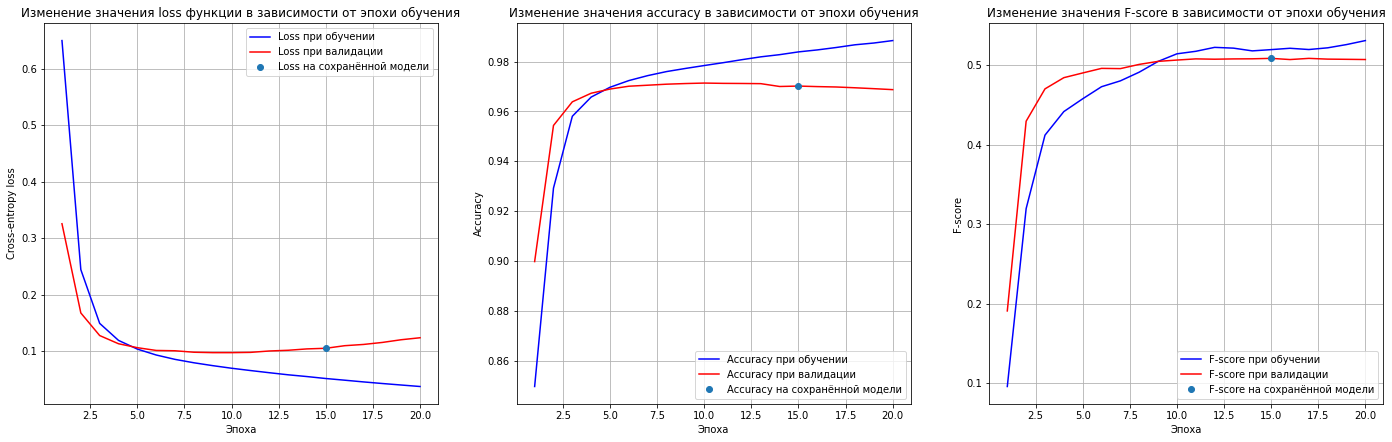

In [443]:
plot_history(history) # вывод истории обучения

### Оценивание качества предсказаний.

In [460]:
model = keras.models.load_model(f"{MODELS_DIR}best_model.keras") # загружаем сохранённую модель

In [ ]:
def model_evaluate(model, X_test, y_test, labels_names=None):
    preds = model.predict(X_test) # делаем предсказание

    if labels_names is None:
        labels_names = y_test.columns # названия таргетов
    if preds.ndim > 1: # если размерность предсказаний больше 1, то есть вектора (размерность 2 — вероятности лейблов) — приводим их к вектору
        preds = np.argmax(preds, axis=-1)  # приводим One-hot encoded предсказания в id ожидаемого таргета
    if y_test.ndim > 1: # если размерность лейблов больше 1, то есть вектора (размерность 2 — вероятности лейблов) — приводим их к вектору
        y_test = np.argmax(y_test, axis=-1) # приводим One-hot encoded лейблы в id ожидаемого таргета
    preds, y_test = preds.flatten(), y_test.flatten() # избавляемся от лишних размерностей (если они остались)

    print(classification_report(y_test, preds, target_names=labels_names, zero_division=0)) # выводим основные метрики, такие как precision, recall, f1-score, accuracy (zero_division=0 — деление на ноль заменять нулём)

    size = len(labels_names) # размер выводимой фигуры зависит от числа классов
    fig, ax = plt.subplots(figsize=(size, size)) # создание "фигуры"
    ConfusionMatrixDisplay(confusion_matrix(y_test, preds, normalize="true"), display_labels=labels_names).plot(ax=ax) # строим confusion matrix (normalize для использования процентного представления вместо точных цифр, true ~ по строкам, all ~ по всей таблице, None ~ использовать обычные цифры предсказаний)
    fig.autofmt_xdate(rotation=45, ha="right") # поворот подписей на оси OX
    plt.show() # показ фигуры

300/300 [==============================] - 36s 121ms/step
              precision    recall  f1-score   support

           O       1.00      1.00      1.00    965541
       B-GEO       0.87      0.89      0.88      7481
       B-GPE       0.96      0.94      0.95      3196
       B-PER       0.85      0.84      0.84      3370
       I-GEO       0.82      0.76      0.79      1486
       B-ORG       0.77      0.75      0.76      3962
       I-ORG       0.79      0.79      0.79      3311
       B-TIM       0.90      0.89      0.90      3986
       B-ART       0.33      0.01      0.03        72
       I-ART       0.00      0.00      0.00        43
       I-PER       0.86      0.88      0.87      3337
       I-GPE       0.81      0.35      0.49        49
       I-TIM       0.76      0.76      0.76      1324
       B-NAT       0.00      0.00      0.00        40
       B-EVE       0.57      0.22      0.31        74
       I-EVE       0.59      0.14      0.23        69
       I-NAT       0.00

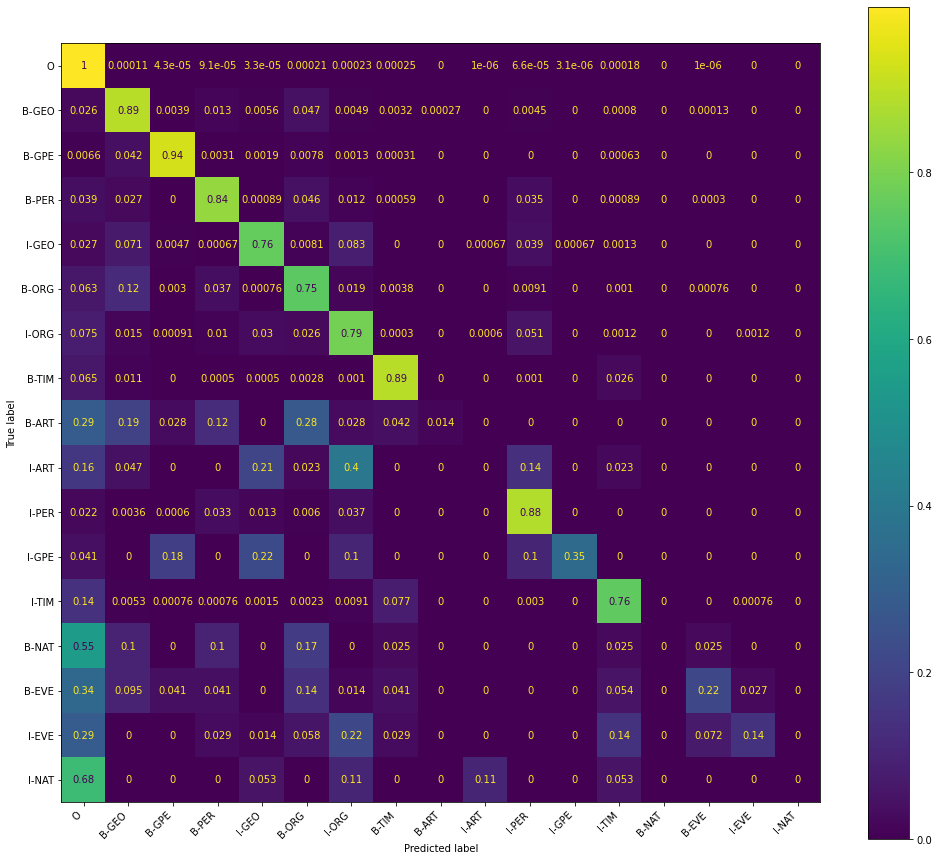

In [474]:
labels = unique_targets # имена таргетов
model_evaluate(model, [X_test_tokens, X_test_pos], y_test, labels) # оцениваем предсказание лучшей модели на соответствующем типе обработки

В результате обучения модель научилась предсказывать большинство классов с довольно неплохой точность. 

Однако, среди плохо предсказываемых оказались следующие: B-ART, I-ART, B-NAT, I_NAT, B-EVE, I-EVE и I_GPE. Скорее всего это связано с их очень слабой представленность в датасете (менее сотни примеров для каждого, < 0.1% от всего датасета). Возможность такого исхода была замечена ещё при анализе гистограммы распределения таргетов.

### Пример работы модели

In [ ]:
st = 7 # с какого сэмпла смотрим
n = 10 # число примеров для рассмотрения
tokens = X_test_tokens[st:st+n] # токены слов первых n предложений для модели
pos = X_test_pos[st:st+n] # POS слов певрых n предложений для модели
tags_true = y_test[st:st+n] # ожидаемые вероятности сущностей (тегов) слов певрых n предложений
tags_pred = model.predict([tokens, pos]) # делаем предсказание

for i in range(n): # идём по первым n тестовы сэмплам
    words = [id2word[id] for id in tokens[i] if id != 0] # конвертируем токены в слова (паддинги пропускаем, они идут с индексом 0)
    words = [word if word != "<OOV>" else "OOV" for word in words] # преобразуем вид токена "<OOV>" в "OOV" чтобы не поломать вывод display
    seq_length = len(words) # длина рассматриваемой последовательности
    tags_true_ = np.argmax(tags_true[i], axis=-1) # id ожидаемой сущности
    tags_true_ = [unique_targets[id] for id in tags_true_[:seq_length]] # конвертируем id в название сущности ([:seq_length] — не рассматриваем паддинги)
    tags_pred_ = np.argmax(tags_pred[i], axis=-1) # id предсказанной сущности
    tags_pred_ = [unique_targets[id] for id in tags_pred_[:seq_length]] # конвертируем id в название сущности ([:seq_length] — не рассматриваем паддинги)
    
    print("Ожидаемое предсказание:")
    print_tagged_text(words, tags_true_)
    print("Полученное предсказание:")
    print_tagged_text(words, tags_pred_)
    print("=" * 100)

1/1 [==============================] - 0s 77ms/step
Ожидаемое предсказание:


<span style='background-color: transparent;'>The</span> <span style='background-color: transparent;'>acting</span> <span style='background-color: transparent;'>head</span> <span style='background-color: transparent;'>of</span> <span style='background-color: transparent;'>the</span> <span style='background-color: darkred;'>AU</span> <span style='background-color: transparent;'>mission</span> <span style='background-color: transparent;'>in</span> <span style='background-color: green;'>Sudan</span> <span style='background-color: transparent;'>,</span> <span style='background-color: blue;'>Jean-Baptiste</span> <span style='background-color: blue;'>Natama</span> <span style='background-color: transparent;'>,</span> <span style='background-color: transparent;'>said</span> <span style='background-color: transparent;'>the</span> <span style='background-color: transparent;'>two</span> <span style='background-color: transparent;'>peacekeeping</span> <span style='background-color: transparent;'>soldiers</span> <span style='background-color: transparent;'>,</span> <span style='background-color: transparent;'>as</span> <span style='background-color: transparent;'>well</span> <span style='background-color: transparent;'>as</span> <span style='background-color: transparent;'>two</span> <span style='background-color: transparent;'>civilian</span> <span style='background-color: transparent;'>contractors</span> <span style='background-color: transparent;'>,</span> <span style='background-color: transparent;'>were</span> <span style='background-color: transparent;'>killed</span> <span style='background-color: yellow;'>Saturday</span> <span style='background-color: transparent;'>during</span> <span style='background-color: transparent;'>a</span> <span style='background-color: transparent;'>surprise</span> <span style='background-color: transparent;'>attack</span> <span style='background-color: transparent;'>in</span> <span style='background-color: green;'>South</span> <span style='background-color: green;'>Darfur</span> <span style='background-color: transparent;'>.</span> 

Полученное предсказание:


<span style='background-color: transparent;'>The</span> <span style='background-color: transparent;'>acting</span> <span style='background-color: transparent;'>head</span> <span style='background-color: transparent;'>of</span> <span style='background-color: transparent;'>the</span> <span style='background-color: darkred;'>AU</span> <span style='background-color: transparent;'>mission</span> <span style='background-color: transparent;'>in</span> <span style='background-color: green;'>Sudan</span> <span style='background-color: transparent;'>,</span> <span style='background-color: blue;'>Jean-Baptiste</span> <span style='background-color: darkred;'>Natama</span> <span style='background-color: transparent;'>,</span> <span style='background-color: transparent;'>said</span> <span style='background-color: transparent;'>the</span> <span style='background-color: transparent;'>two</span> <span style='background-color: transparent;'>peacekeeping</span> <span style='background-color: transparent;'>soldiers</span> <span style='background-color: transparent;'>,</span> <span style='background-color: transparent;'>as</span> <span style='background-color: transparent;'>well</span> <span style='background-color: transparent;'>as</span> <span style='background-color: transparent;'>two</span> <span style='background-color: transparent;'>civilian</span> <span style='background-color: transparent;'>contractors</span> <span style='background-color: transparent;'>,</span> <span style='background-color: transparent;'>were</span> <span style='background-color: transparent;'>killed</span> <span style='background-color: yellow;'>Saturday</span> <span style='background-color: transparent;'>during</span> <span style='background-color: transparent;'>a</span> <span style='background-color: transparent;'>surprise</span> <span style='background-color: transparent;'>attack</span> <span style='background-color: transparent;'>in</span> <span style='background-color: green;'>South</span> <span style='background-color: green;'>Darfur</span> <span style='background-color: transparent;'>.</span> 

Ожидаемое предсказание:


<span style='background-color: transparent;'>He</span> <span style='background-color: transparent;'>was</span> <span style='background-color: transparent;'>re-arrested</span> <span style='background-color: transparent;'>in</span> <span style='background-color: yellow;'>November</span> <span style='background-color: transparent;'>,</span> <span style='background-color: transparent;'>after</span> <span style='background-color: transparent;'>granting</span> <span style='background-color: transparent;'>another</span> <span style='background-color: transparent;'>interview</span> <span style='background-color: transparent;'>in</span> <span style='background-color: transparent;'>which</span> <span style='background-color: transparent;'>he</span> <span style='background-color: transparent;'>said</span> <span style='background-color: green;'>Israel</span> <span style='background-color: transparent;'>has</span> <span style='background-color: transparent;'>up</span> <span style='background-color: transparent;'>to</span> <span style='background-color: transparent;'>200</span> <span style='background-color: transparent;'>atomic</span> <span style='background-color: transparent;'>warheads</span> <span style='background-color: transparent;'>,</span> <span style='background-color: transparent;'>a</span> <span style='background-color: transparent;'>neutron</span> <span style='background-color: transparent;'>bomb</span> <span style='background-color: transparent;'>,</span> <span style='background-color: transparent;'>and</span> <span style='background-color: transparent;'>hydrogen</span> <span style='background-color: transparent;'>bombs</span> <span style='background-color: transparent;'>.</span> 

Полученное предсказание:


<span style='background-color: transparent;'>He</span> <span style='background-color: transparent;'>was</span> <span style='background-color: transparent;'>re-arrested</span> <span style='background-color: transparent;'>in</span> <span style='background-color: yellow;'>November</span> <span style='background-color: transparent;'>,</span> <span style='background-color: transparent;'>after</span> <span style='background-color: transparent;'>granting</span> <span style='background-color: transparent;'>another</span> <span style='background-color: transparent;'>interview</span> <span style='background-color: transparent;'>in</span> <span style='background-color: transparent;'>which</span> <span style='background-color: transparent;'>he</span> <span style='background-color: transparent;'>said</span> <span style='background-color: green;'>Israel</span> <span style='background-color: transparent;'>has</span> <span style='background-color: transparent;'>up</span> <span style='background-color: transparent;'>to</span> <span style='background-color: transparent;'>200</span> <span style='background-color: transparent;'>atomic</span> <span style='background-color: transparent;'>warheads</span> <span style='background-color: transparent;'>,</span> <span style='background-color: transparent;'>a</span> <span style='background-color: transparent;'>neutron</span> <span style='background-color: transparent;'>bomb</span> <span style='background-color: transparent;'>,</span> <span style='background-color: transparent;'>and</span> <span style='background-color: transparent;'>hydrogen</span> <span style='background-color: transparent;'>bombs</span> <span style='background-color: transparent;'>.</span> 

Ожидаемое предсказание:


<span style='background-color: transparent;'>The</span> <span style='background-color: transparent;'>government</span> <span style='background-color: transparent;'>now</span> <span style='background-color: transparent;'>has</span> <span style='background-color: transparent;'>to</span> <span style='background-color: transparent;'>set</span> <span style='background-color: transparent;'>a</span> <span style='background-color: transparent;'>date</span> <span style='background-color: transparent;'>for</span> <span style='background-color: transparent;'>the</span> <span style='background-color: transparent;'>execution</span> <span style='background-color: transparent;'>.</span> 

Полученное предсказание:


<span style='background-color: transparent;'>The</span> <span style='background-color: transparent;'>government</span> <span style='background-color: transparent;'>now</span> <span style='background-color: transparent;'>has</span> <span style='background-color: transparent;'>to</span> <span style='background-color: transparent;'>set</span> <span style='background-color: transparent;'>a</span> <span style='background-color: transparent;'>date</span> <span style='background-color: transparent;'>for</span> <span style='background-color: transparent;'>the</span> <span style='background-color: transparent;'>execution</span> <span style='background-color: transparent;'>.</span> 

Ожидаемое предсказание:


<span style='background-color: transparent;'>The</span> <span style='background-color: transparent;'>prime</span> <span style='background-color: transparent;'>minister</span> <span style='background-color: transparent;'>held</span> <span style='background-color: transparent;'>his</span> <span style='background-color: transparent;'>first</span> <span style='background-color: transparent;'>talks</span> <span style='background-color: transparent;'>with</span> <span style='background-color: transparent;'>a</span> <span style='background-color: orange;'>Kashmiri</span> <span style='background-color: transparent;'>group</span> <span style='background-color: transparent;'>in</span> <span style='background-color: yellow;'>September</span> <span style='background-color: yellow;'>of</span> <span style='background-color: transparent;'>last</span> <span style='background-color: transparent;'>year</span> <span style='background-color: transparent;'>.</span> 

Полученное предсказание:


<span style='background-color: transparent;'>The</span> <span style='background-color: transparent;'>prime</span> <span style='background-color: transparent;'>minister</span> <span style='background-color: transparent;'>held</span> <span style='background-color: transparent;'>his</span> <span style='background-color: transparent;'>first</span> <span style='background-color: transparent;'>talks</span> <span style='background-color: transparent;'>with</span> <span style='background-color: transparent;'>a</span> <span style='background-color: orange;'>Kashmiri</span> <span style='background-color: transparent;'>group</span> <span style='background-color: transparent;'>in</span> <span style='background-color: yellow;'>September</span> <span style='background-color: yellow;'>of</span> <span style='background-color: transparent;'>last</span> <span style='background-color: transparent;'>year</span> <span style='background-color: transparent;'>.</span> 

Ожидаемое предсказание:


<span style='background-color: darkred;'>U.S.</span> <span style='background-color: darkred;'>Undersecretary</span> <span style='background-color: darkred;'>of</span> <span style='background-color: darkred;'>State</span> <span style='background-color: darkred;'>Nicholas</span> <span style='background-color: darkred;'>Burns</span> <span style='background-color: transparent;'>has</span> <span style='background-color: transparent;'>expressed</span> <span style='background-color: transparent;'>doubt</span> <span style='background-color: transparent;'>that</span> <span style='background-color: green;'>Washington</span> <span style='background-color: transparent;'>and</span> <span style='background-color: green;'>New</span> <span style='background-color: green;'>Delhi</span> <span style='background-color: transparent;'>will</span> <span style='background-color: transparent;'>finalize</span> <span style='background-color: transparent;'>a</span> <span style='background-color: transparent;'>nuclear</span> <span style='background-color: transparent;'>deal</span> <span style='background-color: transparent;'>before</span> <span style='background-color: blue;'>President</span> <span style='background-color: blue;'>Bush</span> <span style='background-color: transparent;'>visits</span> <span style='background-color: green;'>India</span> <span style='background-color: transparent;'>next</span> <span style='background-color: transparent;'>week</span> <span style='background-color: transparent;'>.</span> 

Полученное предсказание:


<span style='background-color: darkred;'>U.S.</span> <span style='background-color: darkred;'>Undersecretary</span> <span style='background-color: darkred;'>of</span> <span style='background-color: darkred;'>State</span> <span style='background-color: darkred;'>Nicholas</span> <span style='background-color: darkred;'>Burns</span> <span style='background-color: transparent;'>has</span> <span style='background-color: transparent;'>expressed</span> <span style='background-color: transparent;'>doubt</span> <span style='background-color: transparent;'>that</span> <span style='background-color: green;'>Washington</span> <span style='background-color: transparent;'>and</span> <span style='background-color: darkred;'>New</span> <span style='background-color: darkred;'>Delhi</span> <span style='background-color: transparent;'>will</span> <span style='background-color: transparent;'>finalize</span> <span style='background-color: transparent;'>a</span> <span style='background-color: transparent;'>nuclear</span> <span style='background-color: transparent;'>deal</span> <span style='background-color: transparent;'>before</span> <span style='background-color: blue;'>President</span> <span style='background-color: blue;'>Bush</span> <span style='background-color: transparent;'>visits</span> <span style='background-color: green;'>India</span> <span style='background-color: transparent;'>next</span> <span style='background-color: transparent;'>week</span> <span style='background-color: transparent;'>.</span> 

Ожидаемое предсказание:


<span style='background-color: transparent;'>At</span> <span style='background-color: transparent;'>least</span> <span style='background-color: transparent;'>three</span> <span style='background-color: transparent;'>other</span> <span style='background-color: transparent;'>militants</span> <span style='background-color: transparent;'>were</span> <span style='background-color: transparent;'>killed</span> <span style='background-color: transparent;'>and</span> <span style='background-color: transparent;'>15</span> <span style='background-color: transparent;'>wounded</span> <span style='background-color: transparent;'>as</span> <span style='background-color: green;'>U.S.</span> <span style='background-color: transparent;'>warplanes</span> <span style='background-color: transparent;'>and</span> <span style='background-color: transparent;'>helicopters</span> <span style='background-color: transparent;'>OOV</span> <span style='background-color: transparent;'>OOV</span> <span style='background-color: transparent;'>along</span> <span style='background-color: transparent;'>a</span> <span style='background-color: transparent;'>ridge</span> <span style='background-color: transparent;'>where</span> <span style='background-color: transparent;'>they</span> <span style='background-color: transparent;'>were</span> <span style='background-color: transparent;'>hiding</span> <span style='background-color: transparent;'>.</span> 

Полученное предсказание:


<span style='background-color: transparent;'>At</span> <span style='background-color: transparent;'>least</span> <span style='background-color: transparent;'>three</span> <span style='background-color: transparent;'>other</span> <span style='background-color: transparent;'>militants</span> <span style='background-color: transparent;'>were</span> <span style='background-color: transparent;'>killed</span> <span style='background-color: transparent;'>and</span> <span style='background-color: transparent;'>15</span> <span style='background-color: transparent;'>wounded</span> <span style='background-color: transparent;'>as</span> <span style='background-color: green;'>U.S.</span> <span style='background-color: transparent;'>warplanes</span> <span style='background-color: transparent;'>and</span> <span style='background-color: transparent;'>helicopters</span> <span style='background-color: transparent;'>OOV</span> <span style='background-color: transparent;'>OOV</span> <span style='background-color: transparent;'>along</span> <span style='background-color: transparent;'>a</span> <span style='background-color: transparent;'>ridge</span> <span style='background-color: transparent;'>where</span> <span style='background-color: transparent;'>they</span> <span style='background-color: transparent;'>were</span> <span style='background-color: transparent;'>hiding</span> <span style='background-color: transparent;'>.</span> 

Ожидаемое предсказание:


<span style='background-color: transparent;'>The</span> <span style='background-color: green;'>United</span> <span style='background-color: green;'>States</span> <span style='background-color: transparent;'>is</span> <span style='background-color: green;'>Venezuela</span> <span style='background-color: transparent;'>'s</span> <span style='background-color: transparent;'>largest</span> <span style='background-color: transparent;'>oil</span> <span style='background-color: transparent;'>customer</span> <span style='background-color: transparent;'>.</span> 

Полученное предсказание:


<span style='background-color: transparent;'>The</span> <span style='background-color: green;'>United</span> <span style='background-color: green;'>States</span> <span style='background-color: transparent;'>is</span> <span style='background-color: green;'>Venezuela</span> <span style='background-color: transparent;'>'s</span> <span style='background-color: transparent;'>largest</span> <span style='background-color: transparent;'>oil</span> <span style='background-color: transparent;'>customer</span> <span style='background-color: transparent;'>.</span> 

Ожидаемое предсказание:


<span style='background-color: transparent;'>A</span> <span style='background-color: transparent;'>countryman</span> <span style='background-color: transparent;'>,</span> <span style='background-color: transparent;'>who</span> <span style='background-color: transparent;'>was</span> <span style='background-color: transparent;'>a</span> <span style='background-color: transparent;'>witness</span> <span style='background-color: transparent;'>of</span> <span style='background-color: transparent;'>the</span> <span style='background-color: transparent;'>encounter</span> <span style='background-color: transparent;'>,</span> <span style='background-color: transparent;'>came</span> <span style='background-color: transparent;'>to</span> <span style='background-color: transparent;'>the</span> <span style='background-color: transparent;'>assistance</span> <span style='background-color: transparent;'>of</span> <span style='background-color: transparent;'>the</span> <span style='background-color: transparent;'>eagle</span> <span style='background-color: transparent;'>,</span> <span style='background-color: transparent;'>and</span> <span style='background-color: transparent;'>succeeded</span> <span style='background-color: transparent;'>in</span> <span style='background-color: transparent;'>freeing</span> <span style='background-color: transparent;'>him</span> <span style='background-color: transparent;'>from</span> <span style='background-color: transparent;'>the</span> <span style='background-color: transparent;'>Serpent</span> <span style='background-color: transparent;'>and</span> <span style='background-color: transparent;'>enabling</span> <span style='background-color: transparent;'>him</span> <span style='background-color: transparent;'>to</span> <span style='background-color: transparent;'>escape</span> <span style='background-color: transparent;'>.</span> 

Полученное предсказание:


<span style='background-color: transparent;'>A</span> <span style='background-color: transparent;'>countryman</span> <span style='background-color: transparent;'>,</span> <span style='background-color: transparent;'>who</span> <span style='background-color: transparent;'>was</span> <span style='background-color: transparent;'>a</span> <span style='background-color: transparent;'>witness</span> <span style='background-color: transparent;'>of</span> <span style='background-color: transparent;'>the</span> <span style='background-color: transparent;'>encounter</span> <span style='background-color: transparent;'>,</span> <span style='background-color: transparent;'>came</span> <span style='background-color: transparent;'>to</span> <span style='background-color: transparent;'>the</span> <span style='background-color: transparent;'>assistance</span> <span style='background-color: transparent;'>of</span> <span style='background-color: transparent;'>the</span> <span style='background-color: yellow;'>eagle</span> <span style='background-color: transparent;'>,</span> <span style='background-color: transparent;'>and</span> <span style='background-color: transparent;'>succeeded</span> <span style='background-color: transparent;'>in</span> <span style='background-color: transparent;'>freeing</span> <span style='background-color: transparent;'>him</span> <span style='background-color: transparent;'>from</span> <span style='background-color: transparent;'>the</span> <span style='background-color: transparent;'>Serpent</span> <span style='background-color: transparent;'>and</span> <span style='background-color: transparent;'>enabling</span> <span style='background-color: transparent;'>him</span> <span style='background-color: transparent;'>to</span> <span style='background-color: transparent;'>escape</span> <span style='background-color: transparent;'>.</span> 

Ожидаемое предсказание:


<span style='background-color: transparent;'>The</span> <span style='background-color: transparent;'>craft</span> <span style='background-color: transparent;'>was</span> <span style='background-color: transparent;'>launched</span> <span style='background-color: transparent;'>in</span> <span style='background-color: yellow;'>September</span> <span style='background-color: yellow;'>of</span> <span style='background-color: yellow;'>2003</span> <span style='background-color: transparent;'>,</span> <span style='background-color: transparent;'>and</span> <span style='background-color: transparent;'>began</span> <span style='background-color: transparent;'>orbiting</span> <span style='background-color: transparent;'>the</span> <span style='background-color: transparent;'>moon</span> <span style='background-color: transparent;'>in</span> <span style='background-color: yellow;'>November</span> <span style='background-color: yellow;'>of</span> <span style='background-color: yellow;'>2004</span> <span style='background-color: transparent;'>.</span> 

Полученное предсказание:


<span style='background-color: transparent;'>The</span> <span style='background-color: transparent;'>craft</span> <span style='background-color: transparent;'>was</span> <span style='background-color: transparent;'>launched</span> <span style='background-color: transparent;'>in</span> <span style='background-color: yellow;'>September</span> <span style='background-color: yellow;'>of</span> <span style='background-color: yellow;'>2003</span> <span style='background-color: transparent;'>,</span> <span style='background-color: transparent;'>and</span> <span style='background-color: transparent;'>began</span> <span style='background-color: transparent;'>orbiting</span> <span style='background-color: transparent;'>the</span> <span style='background-color: transparent;'>moon</span> <span style='background-color: transparent;'>in</span> <span style='background-color: yellow;'>November</span> <span style='background-color: yellow;'>of</span> <span style='background-color: yellow;'>2004</span> <span style='background-color: transparent;'>.</span> 

Ожидаемое предсказание:


<span style='background-color: transparent;'>The</span> <span style='background-color: transparent;'>main</span> <span style='background-color: transparent;'>political</span> <span style='background-color: transparent;'>rival</span> <span style='background-color: transparent;'>to</span> <span style='background-color: green;'>Afghanistan</span> <span style='background-color: transparent;'>'s</span> <span style='background-color: blue;'>President</span> <span style='background-color: blue;'>Hamid</span> <span style='background-color: blue;'>Karzai</span> <span style='background-color: transparent;'>has</span> <span style='background-color: transparent;'>formed</span> <span style='background-color: transparent;'>a</span> <span style='background-color: transparent;'>new</span> <span style='background-color: transparent;'>national-level</span> <span style='background-color: transparent;'>political</span> <span style='background-color: transparent;'>party</span> <span style='background-color: transparent;'>called</span> <span style='background-color: darkred;'>New</span> <span style='background-color: darkred;'>Afghanistan</span> <span style='background-color: transparent;'>.</span> 

Полученное предсказание:


<span style='background-color: transparent;'>The</span> <span style='background-color: transparent;'>main</span> <span style='background-color: transparent;'>political</span> <span style='background-color: transparent;'>rival</span> <span style='background-color: transparent;'>to</span> <span style='background-color: green;'>Afghanistan</span> <span style='background-color: transparent;'>'s</span> <span style='background-color: blue;'>President</span> <span style='background-color: blue;'>Hamid</span> <span style='background-color: blue;'>Karzai</span> <span style='background-color: transparent;'>has</span> <span style='background-color: transparent;'>formed</span> <span style='background-color: transparent;'>a</span> <span style='background-color: transparent;'>new</span> <span style='background-color: transparent;'>national-level</span> <span style='background-color: transparent;'>political</span> <span style='background-color: transparent;'>party</span> <span style='background-color: transparent;'>called</span> <span style='background-color: darkred;'>New</span> <span style='background-color: green;'>Afghanistan</span> <span style='background-color: transparent;'>.</span> 

# Rule-based подход для задачи NER

In [ ]:
dataset = pd.read_pickle(f"{DATA_DIR}data_processed.pkl") # считывание данных
texts = dataset["Word"] # берём данные из колонки
texts = [" ".join(word_list) for word_list in texts] # преобразуем список слов в целостную строку
texts[:10] # пример первых десяти строк датасета

['Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .',
 'Iranian officials say they expect to get access to sealed sensitive parts of the plant Wednesday , after an IAEA surveillance system begins functioning .',
 'Helicopter gunships Saturday pounded militant hideouts in the Orakzai tribal region , where many Taliban militants are believed to have fled to avoid an earlier military offensive in nearby South Waziristan .',
 'They left after a tense hour-long standoff with riot police .',
 'U.N. relief coordinator Jan Egeland said Sunday , U.S. , Indonesian and Australian military helicopters are ferrying out food and supplies to remote areas of western Aceh province that ground crews can not reach .',
 'Mr. Egeland said the latest figures show 1.8 million people are in need of food assistance - with the need greatest in Indonesia , Sri Lanka , the Maldives and India .',
 "He said last week 's 

In [ ]:
# import sys
# !{sys.executable} -m spacy download en_core_web_sm
nlp = spacy.load(name="en_core_web_sm") # загрузка предобученной модели с именем name
nlp

In [522]:
doc = nlp(texts[0]) # отправляем данные в модель (doc теперь не просто текст, он также имеет дополнительную информацию)
print(doc)
print(f"Сущности, встреченные в данном документе: {doc.ents} ~ {[ent.label_ for ent in doc.ents]}")

Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
Сущности, встреченные в данном документе: (Thousands, London, Iraq, British) ~ ['CARDINAL', 'GPE', 'GPE', 'NORP']


In [ ]:
displacy.render(doc, style="ent", jupyter=True) # вывод встреченных сущностей

## Подсчёт изначальных метрик Rule-based подхода

Сущности, что уже заложены в spacy.

In [587]:
ner = nlp.get_pipe("ner") # NER компонент из nlp pipeline

print("Доступные сущности (теги):")
for label in ner.labels:
    print(f"* {label} — {spacy.explain(label)}")

Доступные сущности (теги):
* CARDINAL — Numerals that do not fall under another type
* DATE — Absolute or relative dates or periods
* EVENT — Named hurricanes, battles, wars, sports events, etc.
* FAC — Buildings, airports, highways, bridges, etc.
* GPE — Countries, cities, states
* LANGUAGE — Any named language
* LAW — Named documents made into laws.
* LOC — Non-GPE locations, mountain ranges, bodies of water
* MONEY — Monetary values, including unit
* NORP — Nationalities or religious or political groups
* ORDINAL — "first", "second", etc.
* ORG — Companies, agencies, institutions, etc.
* PERCENT — Percentage, including "%"
* PERSON — People, including fictional
* PRODUCT — Objects, vehicles, foods, etc. (not services)
* QUANTITY — Measurements, as of weight or distance
* TIME — Times smaller than a day
* WORK_OF_ART — Titles of books, songs, etc.


In [ ]:
target2spacy = { 
    'O': "O",
    'B-GEO': "LOC", 'I-GEO': "LOC",
    'B-NAT': "LOC", 'I-NAT': "LOC",
    'B-GPE': "GPE", 'I-GPE': "GPE",
    'B-PER': "PERSON", 'I-PER': "PERSON",
    'B-ORG': "ORG", 'I-ORG': "ORG",
    'B-TIM': "TIME", 'I-TIM': "TIME",
    'B-ART': "WORK_OF_ART", 'I-ART': "WORK_OF_ART",
    'B-EVE': "EVENT", 'I-EVE': "EVENT"
    } # словарь мэппинга исходных тегов в spacy

# valid_spacy_targets = ["LOC", "GPE", "PERSON", "ORG", "TIME", "WORK_OF_ART", "EVENT"] # список валидных сущностей для spacy (чтобы нерассматриваемые в датасете сущности не ухудшали метрики) 

Получаем ожидаемые таргеты.

In [589]:
words = dataset["Word"]
tags = dataset["Tag"]
expected_answers = [] # список под ожидаемые сущности вида [[(слово, сущность), ...], [(слово, сущность), ...]]

for i in range(len(dataset)): # идём по количеству сэмплов в датасете
    expected_answers.append([]) # подмассив под пары (слово, сущность) для всех документов в датасете
    for j, tag in enumerate(tags[i]): # идём то тегам (сущностям) предложения i
        if tag != "O": # если тег не означает отсутствие сущности
            expected_answers[i].append((words[i][j], target2spacy[tag])) # добавляем запись о наличии в предложении i слова с сущностью

expected_answers[:3] # сущности в первых трёх предложениях датасета

[[('London', 'LOC'), ('Iraq', 'LOC'), ('British', 'GPE')],
 [('Iranian', 'GPE'), ('Wednesday', 'TIME'), ('IAEA', 'ORG')],
 [('Saturday', 'TIME'),
  ('Orakzai', 'LOC'),
  ('Taliban', 'ORG'),
  ('South', 'LOC'),
  ('Waziristan', 'LOC')]]

Считаем изначально предсказываемые моделью таргеты.

In [ ]:
spacy_answers = [] # список под сущности, найденные с помощью spacy модели

for i in tqdm(range(len(dataset))): # идём по количеству сэмплов в датасете
    spacy_answers.append([]) # подмассив под пары (слово, сущность) для всех документов в датасете
    doc = nlp(texts[i]) # отправляем данные в модель (doc теперь не просто текст, он также имеет дополнительную информацию)
    for entity in doc.ents: # идём по обнаруженным сущностям документа (предложения)
        # if entity.label_ not in valid_spacy_targets: # если наименование рассматриваемой сущности не встречалось в датаете
        #     continue # пропускаем эту сущность
        
        entity_words = entity.text.split() # разделяем сущность на токены по пробелу (spacy токены одной сущности автоматически объединяет)
        for word in entity_words: # идём по отдельным словам (токенам) в сущности
            spacy_answers[i].append((word, entity.label_)) # добавляем запись о найденной сущности

spacy_answers[:3] # сущности, опознанные spacy в первых трёх предложениях датасета

  0%|          | 0/47949 [00:00<?, ?it/s]

[[('Thousands', 'CARDINAL'),
  ('London', 'GPE'),
  ('Iraq', 'GPE'),
  ('British', 'NORP')],
 [('Iranian', 'NORP'), ('Wednesday', 'DATE'), ('IAEA', 'ORG')],
 [('Saturday', 'DATE'),
  ('Orakzai', 'PERSON'),
  ('Taliban', 'ORG'),
  ('South', 'GPE'),
  ('Waziristan', 'GPE')]]

Так как даже предсказываемые таргеты могут не совпадать с ожидаемыми (spacy предсказывает большее количество типов сущностей), то использовать F-score некорректно. Поэтому для измерения качества предсказаний воспользуемся метриками **Accuracy** и **Intersection over Union** (IoU) из CV. IoU измеряется в области от 0 до 1 и чем ближе к 1, тем ближе предсказания модели к ожидаемым.

In [ ]:
def print_metrics(expected_answers, predicted_answers) -> None:
    """
    Функция для вывода метрик сравнения ожидаемых предсказаний и полученных.\n
    Parameters
    -------
    * expected_answers : список списков ожидаемых пар вида (слово, тег сущности)
    * predicted_answers : список списков предсказанных пар вида (слово, тег сущности)
    Returns
    -------
    * None : выводит метрики на экран
    """
    IoU_words = [] # список под значение метрики IoU среди только слов всех предложений (без учитывания поставленных словам сущностей)
    IoU_entity = [] # список под значение метрики IoU для каждого сэмпла-предложения (с учётом, какая сущность у слов)
    accuracy_words = [] # список под значение метрики accuracy среди только слов всех предложений (без учитывания поставленных словам сущностей)
    accuracy_entity = [] # список под значение метрики accuracy для каждого сэмпла-предложения (с учётом, какая сущность у слов)


    for i in range(len(expected_answers)): # идём по количеству сэмплов в датасете
        words_expected = set([pair[0] for pair in expected_answers[i]]) # берём ожидаемые слова предложения i без учёта их тегов и собираем их в set
        words_predicted = set([pair[0] for pair in predicted_answers[i]]) # берём предсказанные слова предложения i без учёта их тегов и собираем их в set
        intersection_words = words_expected.intersection(words_predicted) # пересечение set_ов
        union_words =  words_expected.union(words_predicted) # объединение set_ов
        try:
            IoU_words.append( len(intersection_words) / len(union_words) ) # считаем IoU для слов
        except ZeroDivisionError: # если размер объединения равен нулю, то и пересечение такое же => предсказание совпало с ожиданием и они оба пусты
            IoU_words.append(1)


        entities_expected = set(expected_answers[i]) # set ожидаемых сущностей (слово и его тег)
        entities_predicted = set(predicted_answers[i]) # set предсказанные сущностей (слово и его тег)
        intersection_entity = entities_expected.intersection(entities_predicted) # пересечение set_ов
        union_entity =  entities_expected.union(entities_predicted) # объединение set_ов
        try:
            IoU_entity.append( len(intersection_entity) / len(union_entity) ) # считаем IoU для полных сущностей (слово и его тег)
        except ZeroDivisionError: # если размер объединения равен нулю, то и пересечение такое же => предсказание совпало с ожиданием и они оба пусты
            IoU_entity.append(1)


        try:
            accuracy_words.append( len(intersection_words) / len(words_predicted) ) # считаем accuracy как число совпавших предсказаний, делённое на общее число сделанных предсказаний
        except ZeroDivisionError: # если предсказаний на предложении не сделано => их либо и не должно быть, либо модель ничего не нашла
            if len(words_expected): # если предсказания должны были быть (размер set_а != 0)
                accuracy_words.append(0)
            else: # если предсказаний и не должно было быть
                accuracy_words.append(1)


        try:
            accuracy_entity.append( len(intersection_entity) / len(entities_predicted) ) # считаем accuracy как число совпавших предсказаний, делённое на общее число сделанных предсказаний
        except ZeroDivisionError: # если предсказаний на предложении не сделано => их либо и не должно быть, либо модель ничего не нашла
            if len(entities_expected): # если предсказания должны были быть (размер set_а != 0)
                accuracy_entity.append(0)
            else: # если предсказаний и не должно было быть
                accuracy_entity.append(1)

    print(f"Средний 'Intersection over Union' для только слов: {sum(IoU_words) / len(IoU_words):.3f}.")
    print(f"Средний 'Intersection over Union' для полной сущности (слово + тег): {sum(IoU_entity) / len(IoU_entity):.3f}.")
    print(f"Средний 'Accuracy' для только слов: {sum(accuracy_words) / len(accuracy_words):.3f}.")
    print(f"Средний 'Accuracy' для полной сущности (слово + тег): {sum(accuracy_entity) / len(accuracy_entity):.3f}.")

In [ ]:
print_metrics(expected_answers, spacy_answers)

Средний 'Intersection over Union' для только слов: 0.675.
Средний 'Intersection over Union' для полной сущности (слово + тег): 0.237.
Средний 'Accuracy' для только слов: 0.721.
Средний 'Accuracy' для полной сущности (слово + тег): 0.289.


Согласно полученным **IoU**, <span style="color:yellow">слова найденные spacy совпадают с ожидаемыми на 67.5%</span> (без учёта соответствующих им тегов). 
Если же ещё и учитывать поставленный этим словам тег (тип сущности), то <span style="color:red">количество совпадений падает почти в три раза, до 23.7%</span>.

**Accuracy** spacy модели <span style="color:yellow">составляет 72.1%, если смотреть только на слова</span> (что у них есть некая сущность, пока ещё не выставленная) и <span style="color:red">лишь 28.9%, если учитывать ещё и предсказанную им сущность</span>.

По этим метрикам можно сделать вывод, что **детекция слов с сущностью работает хорошо, однако сами приписываемые словам сущности сильно различаются между датасетом и spacy моделью**. Где для одного слово относится к тегу LOC, то для другого это GPE...

*P.S.* если среди предсказываемых spacy слов оставить только те, что были сметчены с датасетом (удалить сущности, которые не описаны в датасете), то **Accuracy** поднимется до 82.5% (и 43.1% с учётом приписанной сущности), но IoU упадёт до 63.3% (и 32.6% с учётом приписанной сущности).

## Добавление новых правил

Попробуем создать свои собственные правила для детекции сущностей.

In [1002]:
matcher = Matcher(nlp.vocab) # создание отдельного экземпляра Matcher

# Правила для поиска локаций, стран, городов, гор или рек (LOC)
patterns_location = []
patterns_location.append([{"LOWER": {"IN": ["north", "northern", "south", "southern" ,"west", "western", "east", "eastern"]}}, {"POS": "PROPN"}]) # что-то, идущее с частью света, например "North Korea"
patterns_location.append([{"TEXT": {"IN": ["London", "Iraq", "Iran", "Kabul", "Perth", "Philippines", "Orakzai", "Aceh", "U.N.", "U.S.", "Maldives", "Netherlands", "Austria", "Mexico", "Washington", "India", "Asia", "Africa", "China", "Japan", "Russia", "Turkey", "Europe", "Beirut", "Lebanon", "Syria", "Damascus", "Missouri", "Earth", "California", "Mojave", "Pyongyang", "Somalia", "Kostelic", "Cuba", "Florida", "India", "Richter", "Rome", "Egypt"]}}]) # названия стран и городов
patterns_location.append([{"TEXT": {"IN": ["New", "United"]}}, {"TEXT": {"IN": ["York", "States"]}}]) # названия стран и городов из двух токенов
matcher.add("LOC", patterns_location, greedy="LONGEST") # добавление правила 

# Правила для поиска народностей или чего-то, относящегося к стране (GPE)
patterns_gpe = []
patterns_gpe.append([{"POS": "ADJ", "TEXT": {"REGEX": "[A-Z]\w+?(ian)"}}]) # что-то, считающееся прилагательным и начинающееся на заглавную букву, а заканчивающуюся на ian, например "Indonesian" and "Australian"
patterns_gpe.append([{"TEXT": {"IN": ["Lebanese", "Dutch", "Afghan", "British", "American", "Turkish", "Slovene"]}}]) # одиночные точные названия 
matcher.add("GPE", patterns_gpe, greedy="LONGEST") # добавление правила 

# Правила для поиска имён (PERSON)
ban_words_person = ["masters", "day", "week", "month", "free", "trade", "agreement", "north", "northern", "south", "southern" ,"west", "western", "east", "eastern", "union", "senate", "state", "department", "court", "house", "lake", "river", "mountain", "road", "beach", "bank", "united", "x", "new", "city", "fire", "world", "cup", "earth", "corporation", "corp", "corp.", "inc", "geological", "survey"]
patterns_person = []
patterns_person.append([{"TEXT": {"IN": ["Wipha", "Dominguez", "Irving", "Kasuri"]}}]) # имя из одного токена
patterns_person.append([{"POS": "PROPN", "LOWER": {"NOT_IN": ban_words_person}}, {"POS": "PROPN", "LOWER": {"NOT_IN": ban_words_person}}]) # два собственных имени подряд, при этом первое в нижнем регистре (LOWER) не входит в заданный список (NOT_IN)
patterns_person.append([{"POS": "PROPN", "LOWER": {"NOT_IN": ban_words_person}}, {"POS": "PROPN", "LOWER": {"NOT_IN": ban_words_person}}, {"POS": "PROPN", "LOWER": {"NOT_IN": ban_words_person}}]) # три собственных имени подряд
patterns_person.append([{"POS": "PROPN", "LOWER": {"NOT_IN": ban_words_person}}, {"POS": "PROPN", "LOWER": {"NOT_IN": ban_words_person}}, {"POS": "PROPN", "LOWER": {"NOT_IN": ban_words_person}}, {"POS": "PROPN", "LOWER": {"NOT_IN": ban_words_person}}]) # четыре собственных имени подряд
patterns_person.append([{"LOWER": {"FUZZY1": {"IN": ["mr", "president"]}}}, {"POS": "PROPN"}]) # первое слово, приведённое к нижнему регистру (LOWER) похоже (FUZZY1 ~ до 1 исправленой буквы) на "mr" или "president" (IN), а второе слово — имя собственное {"POS": "PROPN"}
matcher.add("PERSON", patterns_person, greedy="LONGEST") # добавление правила 

# Правила для поиска названия организаций (ORG)
possible_words_org = ["United", "Fire", "White", "European", "Nations", "Department", "House", "Union", "State", "Department", "Commission", "Corruption", "Anti", "-"]
patterns_organisation = []
patterns_organisation.append([{"POS": "PROPN"}, {"LOWER": {"REGEX": "^.*(inc|corp).*$"}}]) # названия организаций из двух токенов, заканчивающиеся на inc, corp
patterns_organisation.append([{"LOWER": {"IN": ["al"]}}, {"LOWER": {"IN": ["-"]}}, {"LOWER": {"IN": ["qaida"]}}]) # составные конструкции из трёх токенов, приведённых в нижний регистр (LOWER), например "al-Qaida"
patterns_organisation.append([{"TEXT": {"IN": ["Taliban", "Taleban", "Crips", "IAEA", "KCNA", "Nias", "Sumatra", "Yemen", "US", "EU", "FIFA", "Senate"]}}]) # названия организаций из одного токена
patterns_organisation.append([{"TEXT": {"IN": possible_words_org}}, {"TEXT": {"IN": possible_words_org}}]) # названия организаций из двух токенов
matcher.add("ORG", patterns_organisation, greedy="LONGEST") # добавление правила 

# Правила для поиска записей о времени (TIME)
patterns_time = []
patterns_time.append([{"LOWER": {"FUZZY1": {"IN": ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]}}}]) # дни недели, приведённые к нижнему регистру (LOWER) и похоже (FUZZY1 ~ до 1 исправленой буквы) на значения в спике (IN)
patterns_time.append([{"LOWER": {"FUZZY1": {"IN": ["january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december"]}, "NOT_IN": ["say", "match"]}, "POS": {"NOT_IN": ["ADJ"]}}]) # месяца, приведённые к нижнему регистру (LOWER) и похоже (FUZZY1 ~ до 1 исправленой буквы) на значения в спике (IN) и не являющиеся прилагательными (POS NOT_IN ADJ)
patterns_time.append([{"LOWER": {"IN": ["months"]}}, {"LOWER": {"IN": ["-"]}}, {"LOWER": {"IN": ["long"]}}]) # составные конструкции из трёх токенов, приведённых в нижний регистр (LOWER), например "months-long"
patterns_time.append([{"LOWER": {"IN": ["this", "end", "day"]}}, {"LOWER": {"IN": ["time", "of", "before"]}}]) # составные конструкции из двух токенов, приведённых в нижний регистр (LOWER), например "this time", "end of"
patterns_time.append([{"LOWER": {"IN": ["current", "fiscal", "week", "day", "night", "morning", "evening"]}}]) # составные конструкции из одного токена, приведённых в нижний регистр (LOWER)
patterns_time.append([{"POS": "NUM", "LOWER": {"NOT_IN": ["million"]}, "TEXT": {"REGEX": "^(?!(.*,)).*$"}}]) # простые числа, такие как 11 или eleven (могу захватить и стоимости...) и не входящие в список (NOT_IN) и не нарушаю регулярное выражение (REGEX) на отсутствие запятых
patterns_time.append([{"LOWER": {"REGEX": "\d+?(th|s)"}}]) # слова, оканчивающиеся на th или s, например "19th" или "1990s"
matcher.add("TIME", patterns_time, greedy="LONGEST") # добавление правила 

# Правила для поиска произведений искусства (WORK_OF_ART)
patterns_art = []
patterns_art.append([{"TEXT": {"IN": ["SpaceShipOne"]}}]) # названия произведений искусства из одного токена
patterns_art.append([{"TEXT": {"IN": ["Ansari"]}}, {"TEXT": {"IN": ["X"]}}, {"TEXT": {"IN": ["Prize"]}}]) # названия произведений искусства из трёх токенов
matcher.add("WORK_OF_ART", patterns_art, greedy="LONGEST") # добавление правила 

# Правила для поиска событий и природных явлений (EVENT)
patterns_event = []
patterns_event.append([{"TEXT": {"IN": ["Nanmadol"]}}]) # события из одного токена
patterns_event.append([{"LOWER": {"IN": ["rolling", "memory", "memorial", "may", "australian", "hopman", "open", "masters", "paris", "world"]}}, {"LOWER": {"IN": ["thunder", "day", "week", "month", "year", "open", "cup", "masters", "war"]}}]) # составные конструкции из двух токенов, приведённых в нижний регистр (LOWER), например "Rolling Thunder"
matcher.add("EVENT", patterns_event, greedy="LONGEST") # добавление правила 

#### DEBUG секция для поиска сущностей

In [ ]:
search_entity = "B-ORG" # искомая сущность (нужно менять вручную)
finded_samples = [] # список под найдённые сэмплы с данной сущностью

for i in range(len(dataset)): # идём по датасету
    tags_ = tags[i]
    if search_entity in tags_: # если искомый тег есть в сэмпле
        finded_samples.append([texts[i].split(), tags_]) # запоминаем его слова и их теги
 
print(f"Количество сэмплов с искомой сущностью: {len(finded_samples)}.")

Количество сэмплов с искомой сущностью: 15758.


In [ ]:
# "LOC": "green", 
# "GPE": "orange",
# "PERSON": blue
# "ORG": "darkred"
# "TIME": yellow
# "B-ART": "pink", "I-ART": "pink", 
# "NAT": "lime" (заболевания, не предсказываются spacy, поэтому пропущены)
# "EVENT": "coral"

sample_id = 0 # номер рассматриваемого сэмпла
print_tagged_text(finded_samples[sample_id][0], finded_samples[sample_id][1])

<span style='background-color: orange;'>Iranian</span> <span style='background-color: transparent;'>officials</span> <span style='background-color: transparent;'>say</span> <span style='background-color: transparent;'>they</span> <span style='background-color: transparent;'>expect</span> <span style='background-color: transparent;'>to</span> <span style='background-color: transparent;'>get</span> <span style='background-color: transparent;'>access</span> <span style='background-color: transparent;'>to</span> <span style='background-color: transparent;'>sealed</span> <span style='background-color: transparent;'>sensitive</span> <span style='background-color: transparent;'>parts</span> <span style='background-color: transparent;'>of</span> <span style='background-color: transparent;'>the</span> <span style='background-color: transparent;'>plant</span> <span style='background-color: yellow;'>Wednesday</span> <span style='background-color: transparent;'>,</span> <span style='background-color: transparent;'>after</span> <span style='background-color: transparent;'>an</span> <span style='background-color: darkred;'>IAEA</span> <span style='background-color: transparent;'>surveillance</span> <span style='background-color: transparent;'>system</span> <span style='background-color: transparent;'>begins</span> <span style='background-color: transparent;'>functioning</span> <span style='background-color: transparent;'>.</span> 

In [ ]:
doc = nlp(" ".join(finded_samples[sample_id][0])) # разбиваем преобразовываем последовательность слов в spacy документ 
print([(token, token.pos_) for token in doc])

matches = matcher(doc) # применение Matcher_а

# Вывод найденных сущностей
for match_id, start, end in matches:
    tag = nlp.vocab.strings[match_id] # берём название тега, так как он изначально кодируется как id_шник (match_id = 380 => PERSON)
    span = doc[start:end] # найденный фрагмент текста
    print(f"Найдены слова: {span.text.split()} с сущностью {match_id} ~ {tag} (start token: {start}, end token: {end}).")

[(Iranian, 'ADJ'), (officials, 'NOUN'), (say, 'VERB'), (they, 'PRON'), (expect, 'VERB'), (to, 'PART'), (get, 'VERB'), (access, 'NOUN'), (to, 'ADP'), (sealed, 'VERB'), (sensitive, 'ADJ'), (parts, 'NOUN'), (of, 'ADP'), (the, 'DET'), (plant, 'NOUN'), (Wednesday, 'PROPN'), (,, 'PUNCT'), (after, 'SCONJ'), (an, 'DET'), (IAEA, 'PROPN'), (surveillance, 'NOUN'), (system, 'NOUN'), (begins, 'VERB'), (functioning, 'VERB'), (., 'PUNCT')]
Найдены слова: ['Iranian'] с сущностью 384 ~ GPE (start token: 0, end token: 1).
Найдены слова: ['Wednesday'] с сущностью 392 ~ TIME (start token: 15, end token: 16).
Найдены слова: ['IAEA'] с сущностью 383 ~ ORG (start token: 19, end token: 20).


Вообще говоря, правила можно составить почти под все сэмплы в датасете, правда это займёт очень много времени...

## Подсчёт новых метрик обновлённого Rule-based подхода

In [1013]:
matcher_answers = [] # список под сущности, найденные с помощью spacy Matcher_а

for i in tqdm(range(len(dataset))): # идём по количеству сэмплов в датасете
    matcher_answers.append([]) # подмассив под пары (слово, сущность) для всех документов в датасете
    doc = nlp(texts[i]) # отправляем данные в модель (doc теперь не просто текст, он также имеет дополнительную информацию)
    
    matches = matcher(doc) # применение Matcher_а
    for match_id, start, end in matches: # идём по обнаруженным сущностям документа (предложения)        
        entity_words = doc[start:end].text.split() # разделяем сущность на токены по пробелу (spacy токены одной сущности автоматически объединяет)
        for word in entity_words: # идём по отдельным словам (токенам) в сущности
            matcher_answers[i].append((word, nlp.vocab.strings[match_id])) # добавляем запись о найденной сущности

matcher_answers[:3] # сущности, опознанные Matcher_ом в первых трёх предложениях датасета

  0%|          | 0/47949 [00:00<?, ?it/s]

[[('London', 'LOC'), ('Iraq', 'LOC'), ('British', 'GPE')],
 [('Iranian', 'GPE'), ('Wednesday', 'TIME'), ('IAEA', 'ORG')],
 [('Saturday', 'TIME'),
  ('South', 'LOC'),
  ('Waziristan', 'LOC'),
  ('Orakzai', 'LOC'),
  ('Taliban', 'ORG')]]

In [1017]:
print_metrics(expected_answers, matcher_answers)

Средний 'Intersection over Union' для только слов: 0.567.
Средний 'Intersection over Union' для полной сущности (слово + тег): 0.446.
Средний 'Accuracy' для только слов: 0.704.
Средний 'Accuracy' для полной сущности (слово + тег): 0.568.


В результате, за несколько часов отсмотра сущностей в датасете и написания правил, получились следующие метрики:
* **IoU** <span style="color:yellow">56.7% при рассмотрении только опознанных слов</span> и не сильно ухудшившийся до <span style="color:yellow">44.6% при добавлении им тега сущности</span>. Данная метрика <span style="color:red">упала на 11%</span> (с 67.5% до 56.7%) при детекции только слов (имеющих некую, пока не проставленную сущность) по сравнению с готовой spacy моделью, но при этом <span style="color:green">выросла на 21%</span> (с 23.7% до 44.6%) при присваивании этим словам определённых тегов (рассмотрение пар слово и его сущность).
* **Accuracy** <span style="color:yellow">70.4% при работе только со словами (без указания тегов)</span> и <span style="color:yellow">56.8% при рассмотрении ещё и проставленных им тегов</span>. Данная метрика уже <span style="color:orange">почти не уступает готовой spacy модели</span> (70.4% vs 72.1%) при работе только со словами, а при тегировании написанные правила так и вовсе <span style="color:green">значительно опережают изначальную модель</span> (56.8% > 28.9%).

Обобщив, написанных правил недостаточно для покрытия всех данных (изначальная spacy модель находит больше "важных" слов), однако качество расставляемых на этих словах меток сущности гораздо лучше при рукописных правилах, что во многом связано с тем, что spacy модель была обучена для работы с метками другого типа (которых даже нет в датасете).

# Выводы

***Подход с применением нейронных сетей***:
* Обучение модели для задачи NER происходит относительно быстро.
* Выдаёт отличные предсказания тегов, что хорошо представлены в датасете.
* Плохо распознаёт сущности, доля которых в данных очень мала.

***Rule-based подход***:
* Требует гораздо больше времени для написания соответствующих правил, по которым идёт поиск сущностей.
* При применение стандартных правил выдаёт средние или даже слабые метрики. Однако, при желании, можно написать особое правило под каждую встреченную сущность в датасете, тем самым сделав его предсказания чуть ли не идеальными.
* При изменении датасета (появлении новых документов) старые правила возможно придётся дополнять.

Как итог, получаем следующее:
1) Если есть *очень много времени и важно качество* предсказаний, то **Rule-based** подход будет предпочтительнее (но в перспективе его тяжело поддерживать).
2) Если же *достаточно хорошей точности и времени мало*, то обучение **нейронных сетей** будет выгоднее.